## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize, special, interpolate, integrate, sparse
from tqdm import tqdm
import time
import utils
from firm import Firm
from utils import COLORS, COLORS_SSP, SECTORS, SCENARIOS

# For reproductibility
SEED = 1234

# Set default matplotlib parameters
plt.rcParams["figure.figsize"] = [9.0, 7.0]
sns.set_style(
    style="ticks",
    rc={
        "axes.grid": True,
        "axes.spines.top": False,
        "axes.spines.right": False,
    },
)
sns.set_context(
    context="poster",
    rc={
        "grid.linewidth": 1.0,
        "legend.fontsize": "x-small",
        "legend.title_fontsize": "xx-small",
    },
)

In [2]:
# Set maturities
# t=0 corresponds to the year 2015

T_ssp_initial = 2015.0
T_ssp_final = 2100.0
T_final = T_ssp_final - T_ssp_initial

# Model

<font color="blue">We introduce some notations. Details can be found in the paper.</font>

For each obligor $i \in \{1,\ldots,n\}$, we model the log production $p_t^i$ as
$$
    dp_t^i
    =
    \left(a^i -b^i p_t^i + \sum_{e} c_e^i \times \gamma_{e,t}^i 
    \times \theta_{e,t}^i\right) + \sigma^i dW_t^i
$$
where
$$
    dW_t^i = \rho^i \, dB_t + \sqrt{1 - (\rho^i)^2} \, dB_t^i
$$
with correlations $\rho^i \in (-1,1)$ and $B, B^1,\dots,B^n$ are $n+1$ 
standard Browian motions.

$B$ reads as a systemic risk factor and the $(B^{i})_{1\leq i\leq n}$ as independent 
idiosyncratic risk factors.


The portfolio loss is given by
$$
    \mathcal{L}_t = \frac{1}{n} \sum_{i=1}^{n}
    \Lambda^i \mathbf{1}_{\widehat{V}_{t}^{i} \leq L^i(t)}
$$
where $\widehat{V}_{t}^{i} = h^i (t, \widehat{p}_{t}^{i})$
with $h^i(\cdot,\cdot)$ some deterministic function
and $\Lambda^i$ is the exposure at default (EAD) times
the loss given default (LGD).

Conditionally on $\mathcal{F}_{t}$, 
the optimal log production
$\big(\widehat{p}_{u}^{i}\big)_{1\leq i\leq n}$
is an $n$-dimensional Gaussian vector with conditional mean
$$
    \mathbb{E}\big[\widehat{p}_{u}^{i} | \mathcal{F}_{t}\big]
    =
    e^{-b^i(u-t)} \widehat{p}_{t}^{i} + m^{i}(u,t),
$$
where
$$
    m^i \big( t, u \big)
    =
    \frac{a^i}{b^i} (1 - e^{-b^i (u - t)})
    +
    \int_t^u e^{-b^i (u - s)} \sum_{e} c^i_e \,
    \theta^i_{e,s} \, \widehat{\gamma}^i_{e, s} \, ds
$$
and conditional covariance
$$
    \mathrm{Cov}\big(\widehat{p}_{u}^{i} \, \widehat{p}_{u}^{j}  | \mathcal{F}_t\big)
    =
    \sigma^{i}\sigma^{j}
    \left(\rho^{i}\rho^{j}{\bf 1}_{i\neq j}+{\bf 1}_{i=j}\right)
    \frac{1-e^{-(b^i+b^j)(u-t)}}{b^i+b^j},
$$
for every $i,j \in \{1,\ldots,n\}$.

We can rewrite the default event as
$$
    \{
        \widehat{V}_{t}^{i} \leq L^i(t)
    \}
    =
    \{
        h^{i} (t, \widehat{p}^i_t) \leq L^i(t)
    \}
    =
    \{
        A_t^i = X_t^i
    \}
$$
where
$$
    A_t^i = \frac{1}{\sigma^i}
        \left[
        e^{-b^i t} \, \widehat{p}_0^{i}
        +
        m^{i}(t,0)
        +
        \sigma^i\sqrt{1-(\rho^i)^{2}}\int_{0}^{t}e^{-b^i(t-s)} \, dB_{s}^{i}
        -
        (h^{i} (t,\cdot))^{-1} (L^{i}(t))
        \right]
$$
and
$$
    X_t^i = -\rho^i \int_{0}^{t} e^{-b^i(t-s)} \, dB_{s}
$$

## One obligor

We pick one firm and plot its
- associated SSP, 
- optimal emission, 
- optimal production,
- optimal value.

This was the study of the [paper](https://cnrs.hal.science/hal-03458299/document).

In [3]:
# Pick a sector from SECTORS
sector = SECTORS[1]
print(sector)

Industrial Sector


In [4]:
# Set parameters
params_firm = {
    "P0": 1.0,
    "r": 0.02,
    "sig": 0.1,
    "a": 0.1,
    "b": 0.1,
    "c": np.array([0.01, 0.01, 0.01]),
    "n_units": 1,
    "w_1": 0.05,
    "w_2": 0.02,
    "alpha": np.array([0.0, 0.0, 0.0]),
    "beta": np.array([0.1, 0.5, 0.8]),
    "theta": np.array([1.0, 1.0, 1.0]),
    "T_final": T_final,
}

In [5]:
# Create dictionnary of firms for each scenario
firms_dict = {}
for scenario in SCENARIOS:
    print(scenario)
    firms_dict[scenario] = Firm(**params_firm, scenario=scenario, sector=sector)

SSP1-26
SSP2-45
SSP3-70 (Baseline)
SSP4-60
SSP5-85 (Baseline)


In [6]:
# Define unpenalized firm
params_firm_no_pen = params_firm.copy()
params_firm_no_pen.update({"w_1": 0.0, "w_2": 0.0})
firm_no_pen = Firm(**params_firm_no_pen, scenario=scenario, sector=sector)

In [7]:
# Define timegrid for plots
nT = 200
tab_T = np.linspace(0.0, T_final, nT)

### SSPs $\widetilde{\gamma}_t$ for a given firm

We pick one specific SSP and plot the different optimal functions.

In [8]:
scenario = "SSP4-60"
firm0 = firms_dict[scenario]

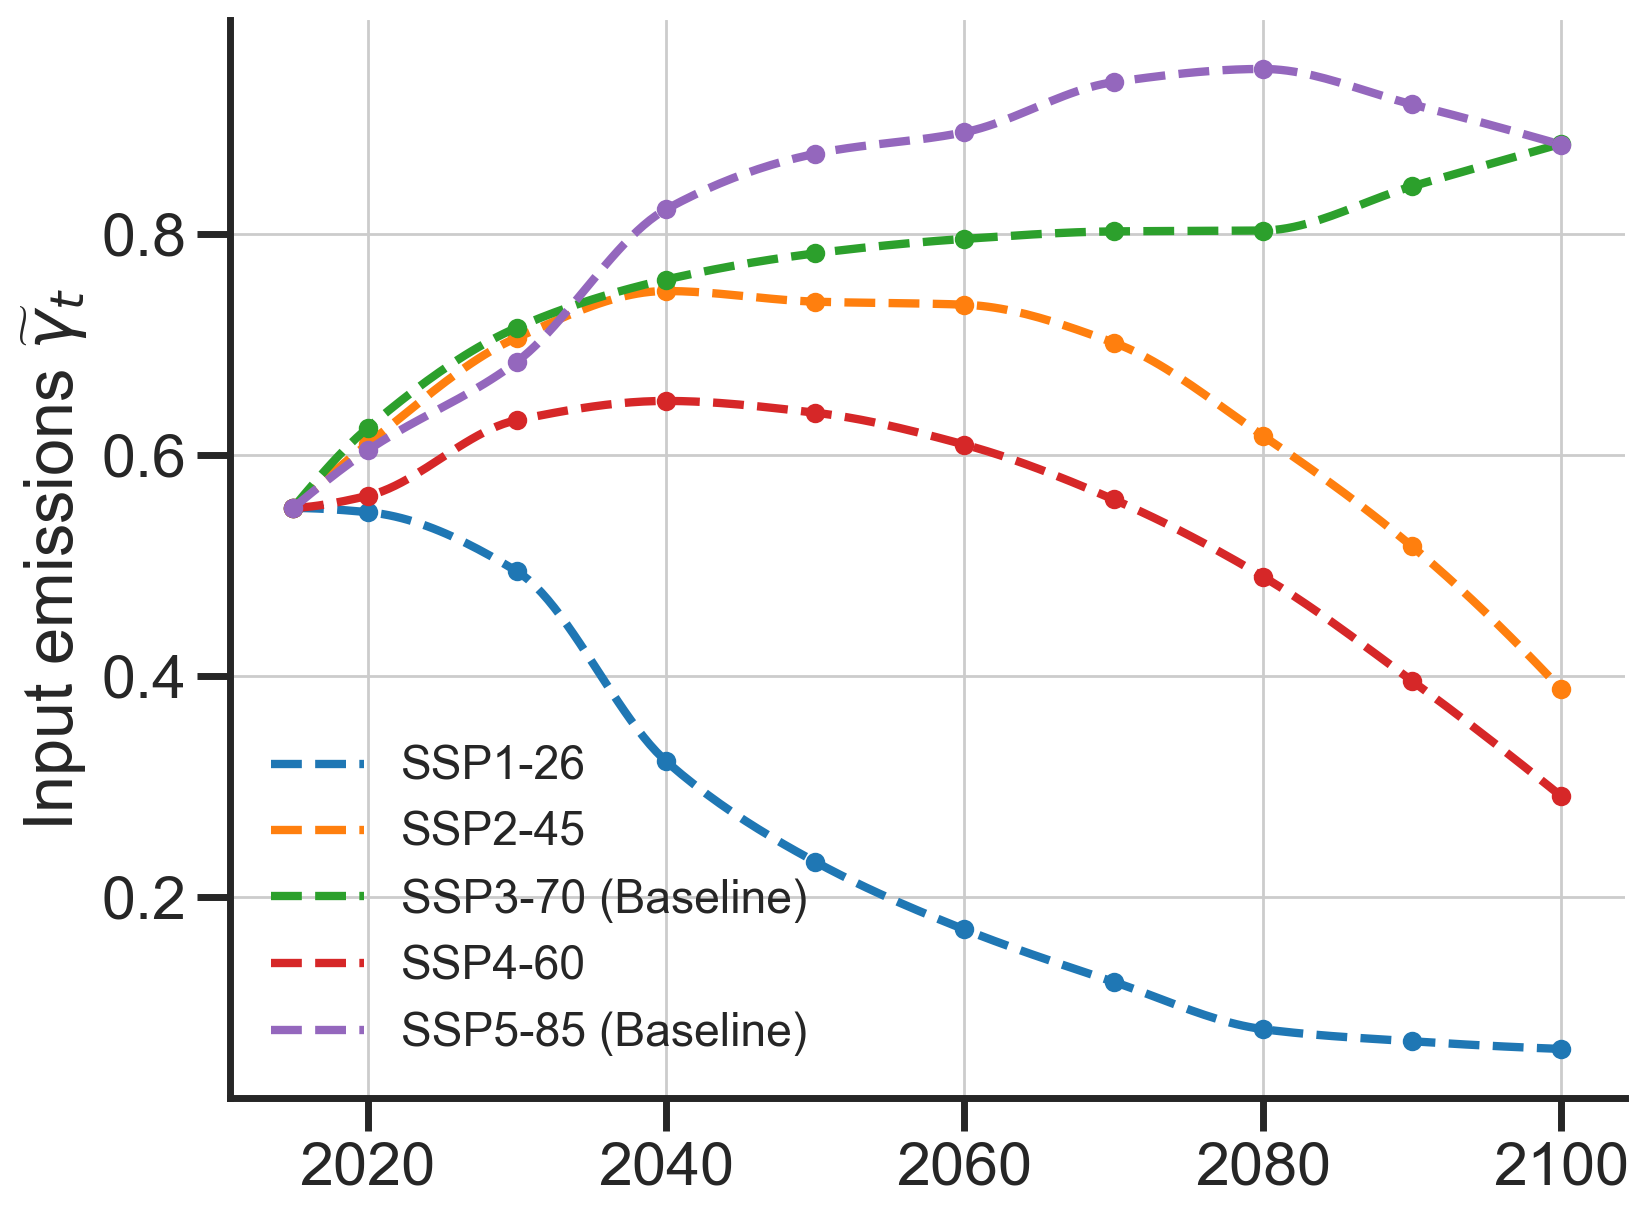

In [9]:
fig, ax = plt.subplots()
for i, name in enumerate(SCENARIOS):
    _firm = firms_dict[name]
    ax.plot(
        T_ssp_initial + tab_T,
        _firm.f_scenario(tab_T),
        "--",
        label=name,
        color=COLORS[i],
    )
    ax.plot(
        T_ssp_initial + _firm.ssp_time,
        _firm.ssp_values,
        ".",
        color=COLORS[i],
    )
ax.legend(
    loc="best",
    framealpha=0.0,
)
ax.set_ylabel("Input emissions $\\widetilde{{\\gamma}}_t$")
plt.show()

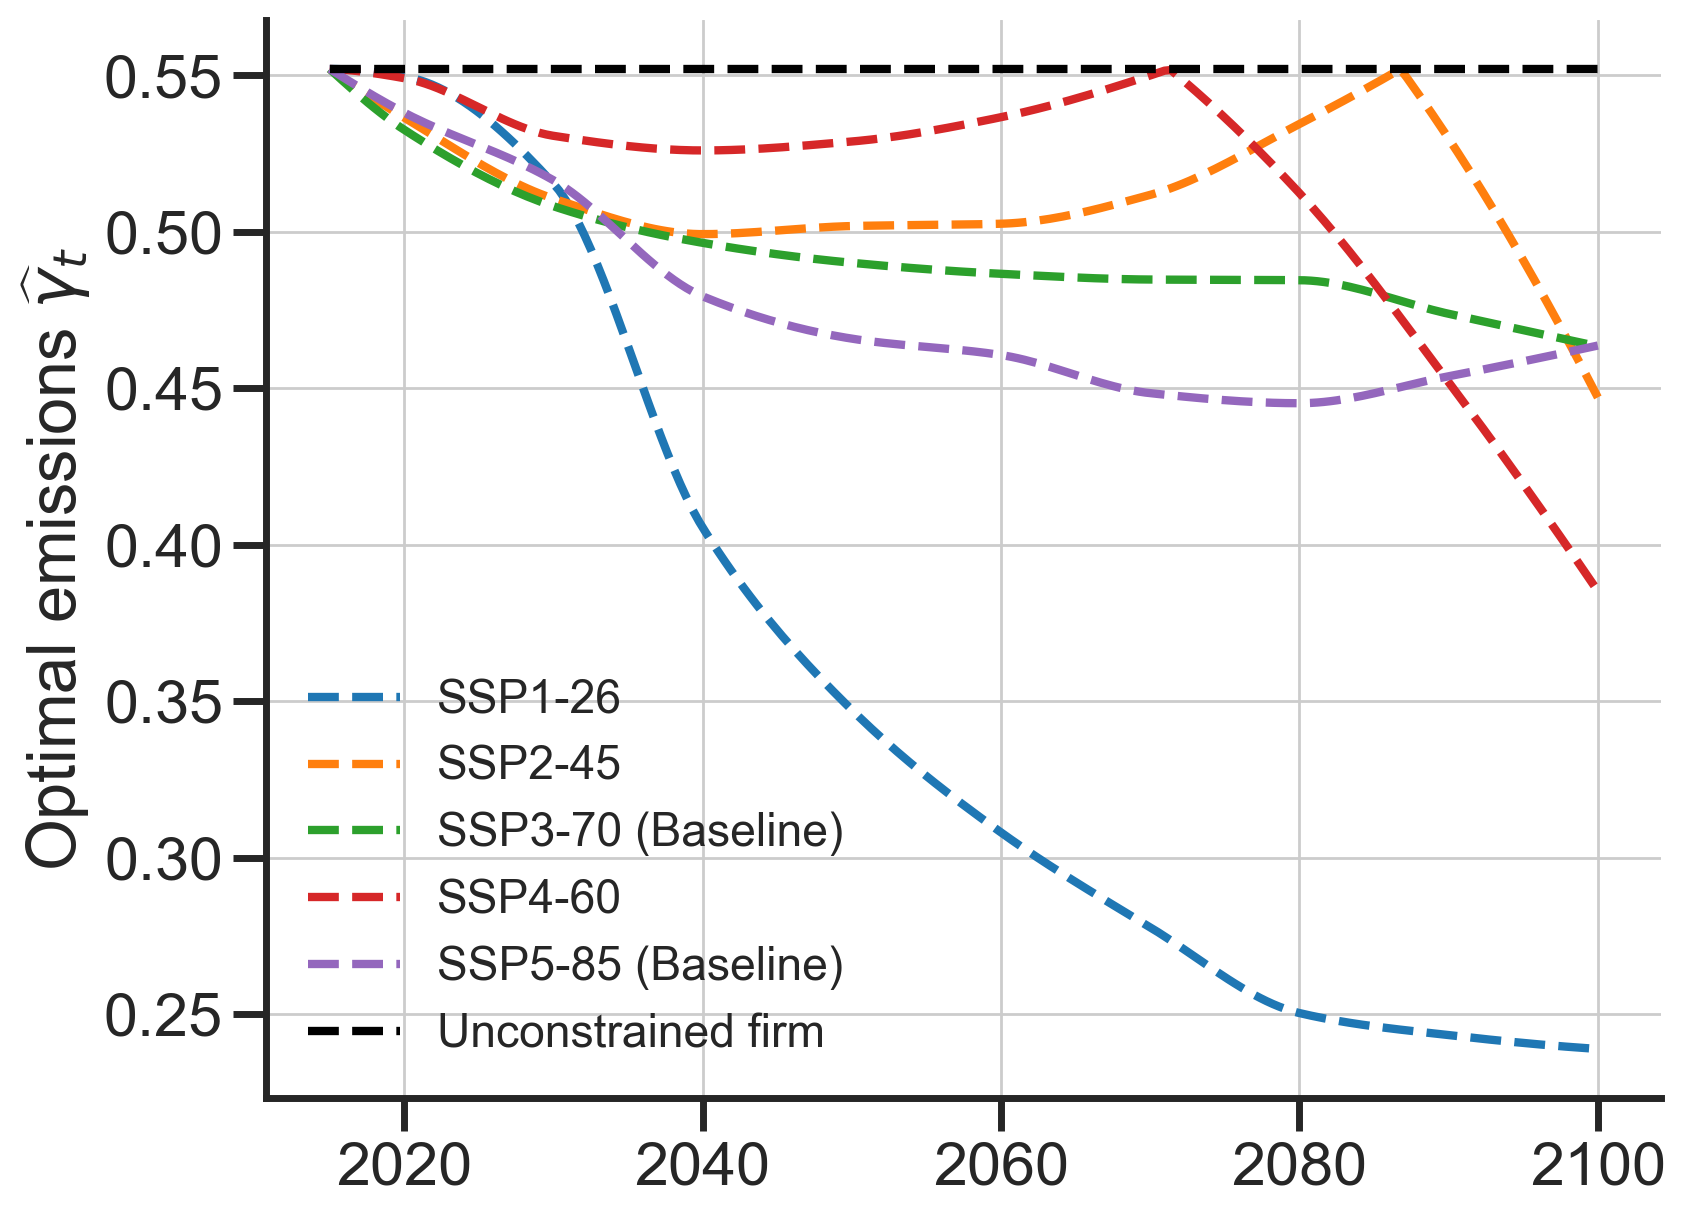

In [10]:
fig, ax = plt.subplots()
for scenario_name, firm in firms_dict.items():
    ax.plot(
        T_ssp_initial + tab_T,
        firm.gamma_optimal_energy(tab_T).sum(axis=0),
        "--",
        label=scenario_name,
    )
ax.plot(
    T_ssp_initial + tab_T,
    firm0.gamma_zero_w * np.ones_like(tab_T),
    "k--",
    label="Unconstrained firm",
)
ax.set_ylabel("Optimal emissions $\\widehat{{\\gamma}}_t$")
ax.legend(loc="lower left", framealpha=0, ncol=1)
plt.show()

For one given SSP, we decompose the optimal emissions response for each energy types.

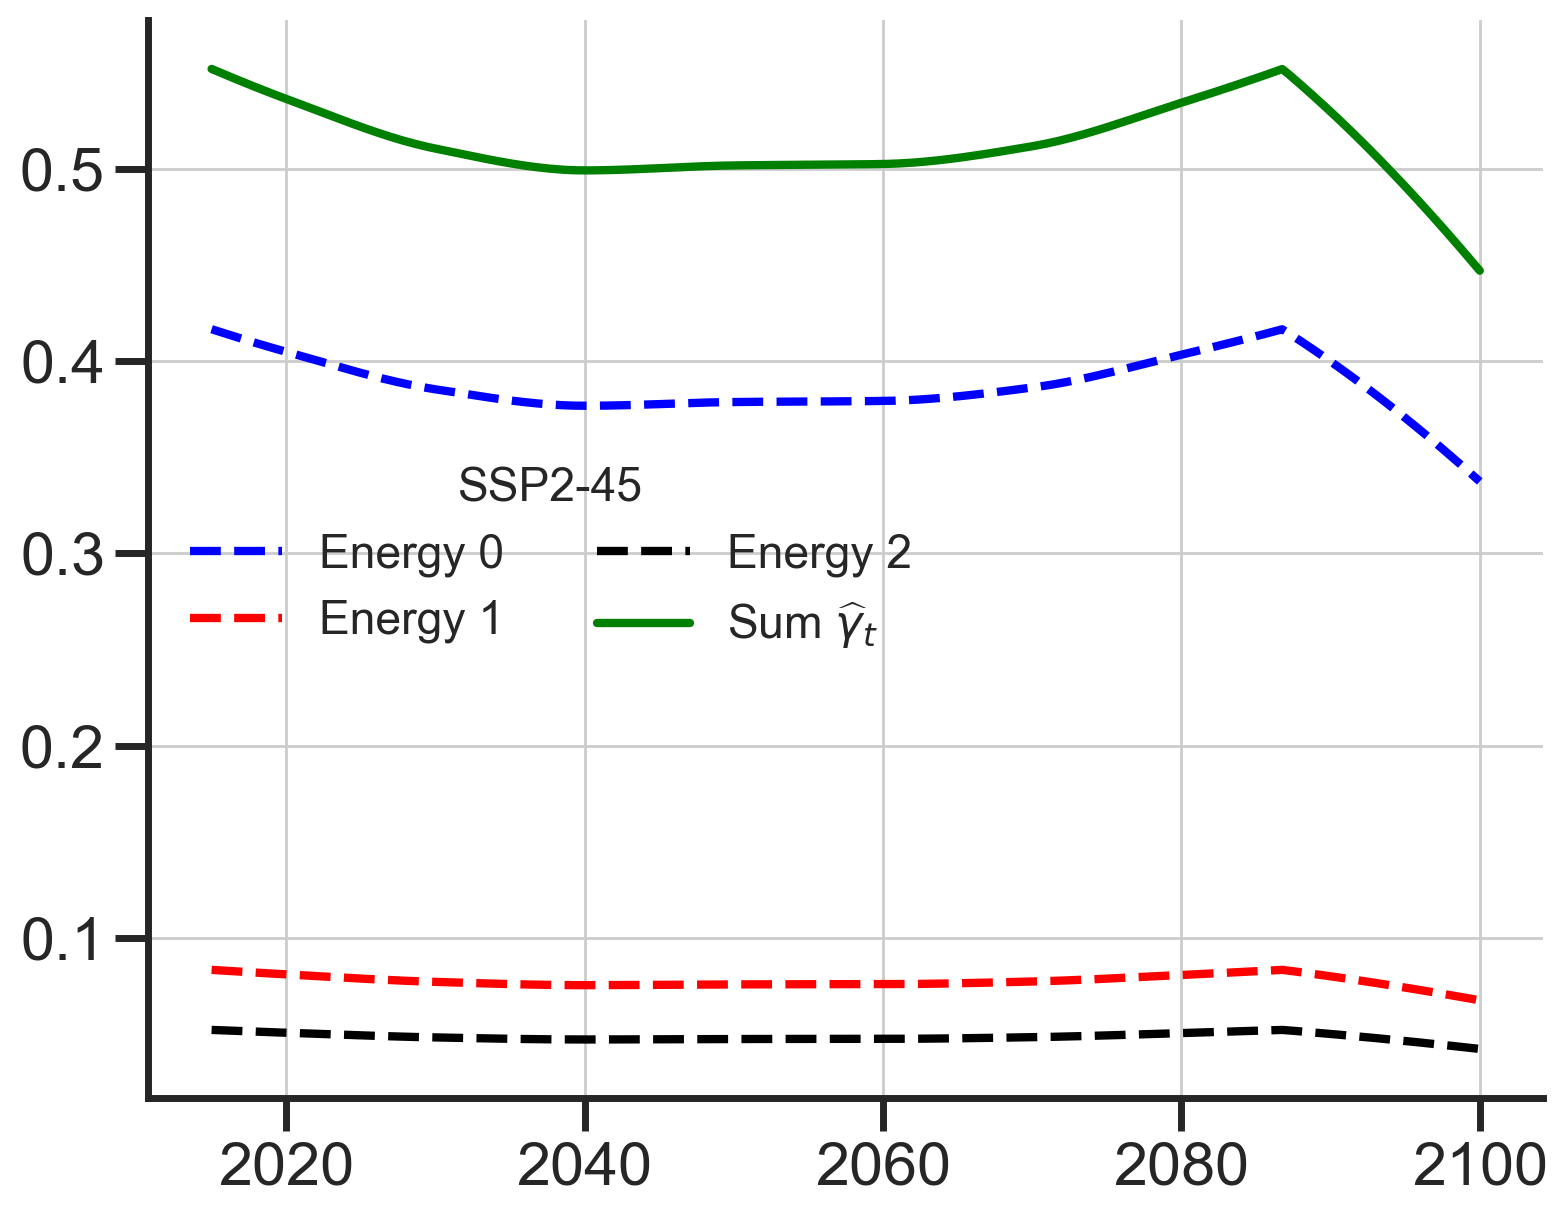

In [11]:
markers = ["b--", "r--", "k--"]
ssp_name = "SSP2-45"
gam_opt = firms_dict[ssp_name].gamma_optimal_energy(tab_T)

fig, ax = plt.subplots()
for i in range(gam_opt.shape[0]):
    plt.plot(T_ssp_initial + tab_T, gam_opt[i, :], markers[i], label=f"Energy {i}")
ax.plot(
    T_ssp_initial + tab_T,
    gam_opt.sum(axis=0),
    color="green",
    label="Sum $\\widehat{\\gamma}_t$",
)
ax.legend(framealpha=0.0, title=ssp_name, title_fontsize="x-small", loc="best", ncol=2)
plt.show()

### Optimal production

For all $u \geq t \geq 0$, conditionally on $\mathcal{F}_t$, $\widehat{p}_t$ is normal 
with conditional mean
$$
    e^{-b (u - t)} \widehat{p}_t + m \big( t, u \big)
$$
where 
$$
    m \big( t, u \big) 
    =  
    \frac{a}{b} (1 - e^{-b (u - t)}) 
    + 
    \int_t^u e^{-b (u - s)} \sum_{e} c_e \, 
    \theta_{e,s} \, \widehat{\gamma}_{e, s} \, ds
$$
and conditial variance
$$
    \sigma^2 \frac{1-e^{-2 b (u-t)}}{2b}.
$$

In [ ]:
# Log production dictionary for all SSPs
log_prod_dict = dict()
for scenario_name, firm in tqdm(firms_dict.items()):
    log_prod_dict[scenario_name] = firm.optimal_log_prod(
        tab_T=tab_T, n_mc=1, seed=SEED
    ).flatten()

100%|██████████| 5/5 [00:00<00:00, 21.72it/s]


In [26]:
# Log production for the unpenalized firm
log_prod_no_pen = firm_no_pen.optimal_log_prod(tab_T=tab_T, n_mc=1, seed=SEED).flatten()

In [27]:
log_prod_no_pen.shape

(200,)

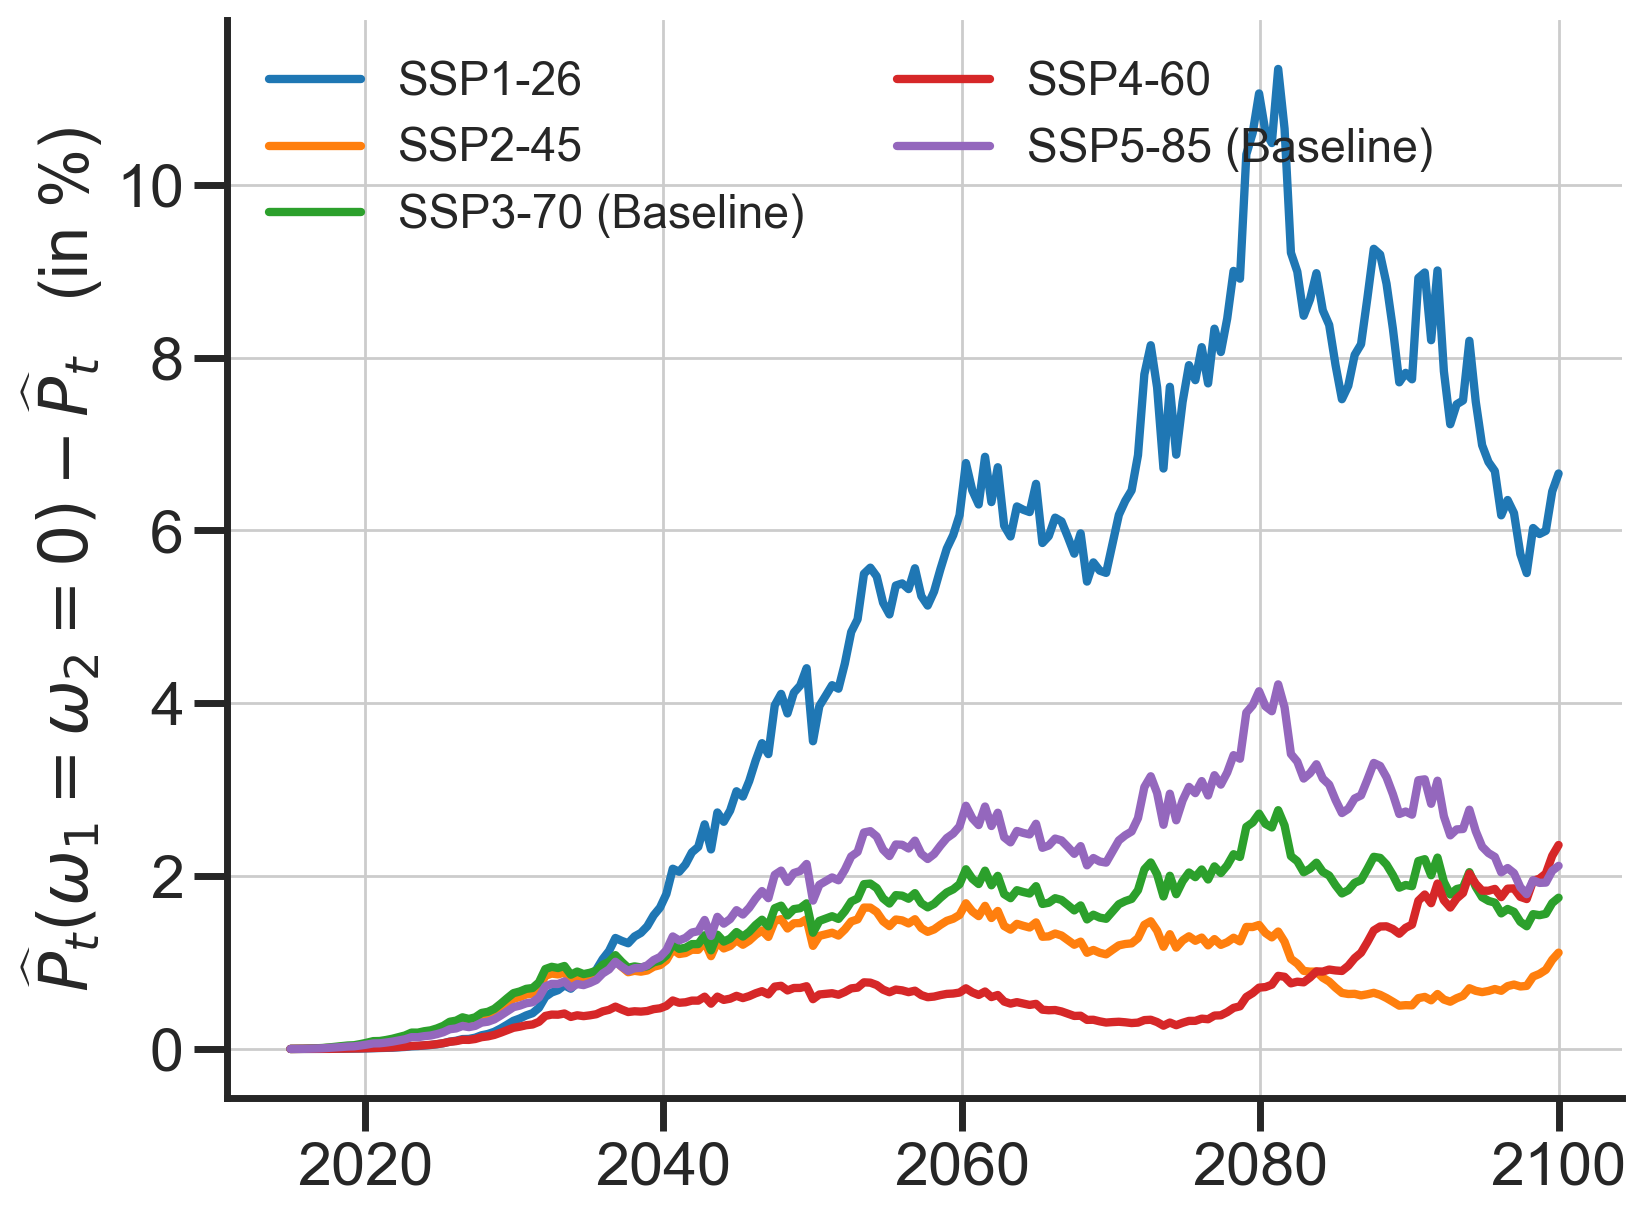

In [28]:
fig, ax = plt.subplots()
for scenario_name, log_prod in log_prod_dict.items():
    ax.plot(
        T_ssp_initial + tab_T,
        100 * (np.exp(log_prod_no_pen) - np.exp(log_prod)),
        "-",
        label=scenario_name,
    )
ax.set_ylabel("$\\widehat{P}_t(\\omega_1=\\omega_2=0) - \\widehat{P}_t$   (in %)")
ax.legend(loc="upper left", framealpha=0, ncol=2)
plt.show()

In [29]:
# Optimal firm's value for each scenario
value_dict = dict()
for scenario_name, firm in firms_dict.items():
    print(scenario_name)
    value_dict[scenario_name] = np.array(
        [firm.h(t=t, x=log_prod_dict[scenario_name][i]) for i, t in enumerate(tab_T)]
    ).flatten()

SSP1-26
SSP2-45
SSP3-70 (Baseline)
SSP4-60
SSP5-85 (Baseline)


In [30]:
# Optimal firm's value for the unpenalized firm
value_no_pen = np.array(
    [firm_no_pen.h(t=t, x=log_prod_no_pen[i]) for i, t in enumerate(tab_T)]
).flatten()

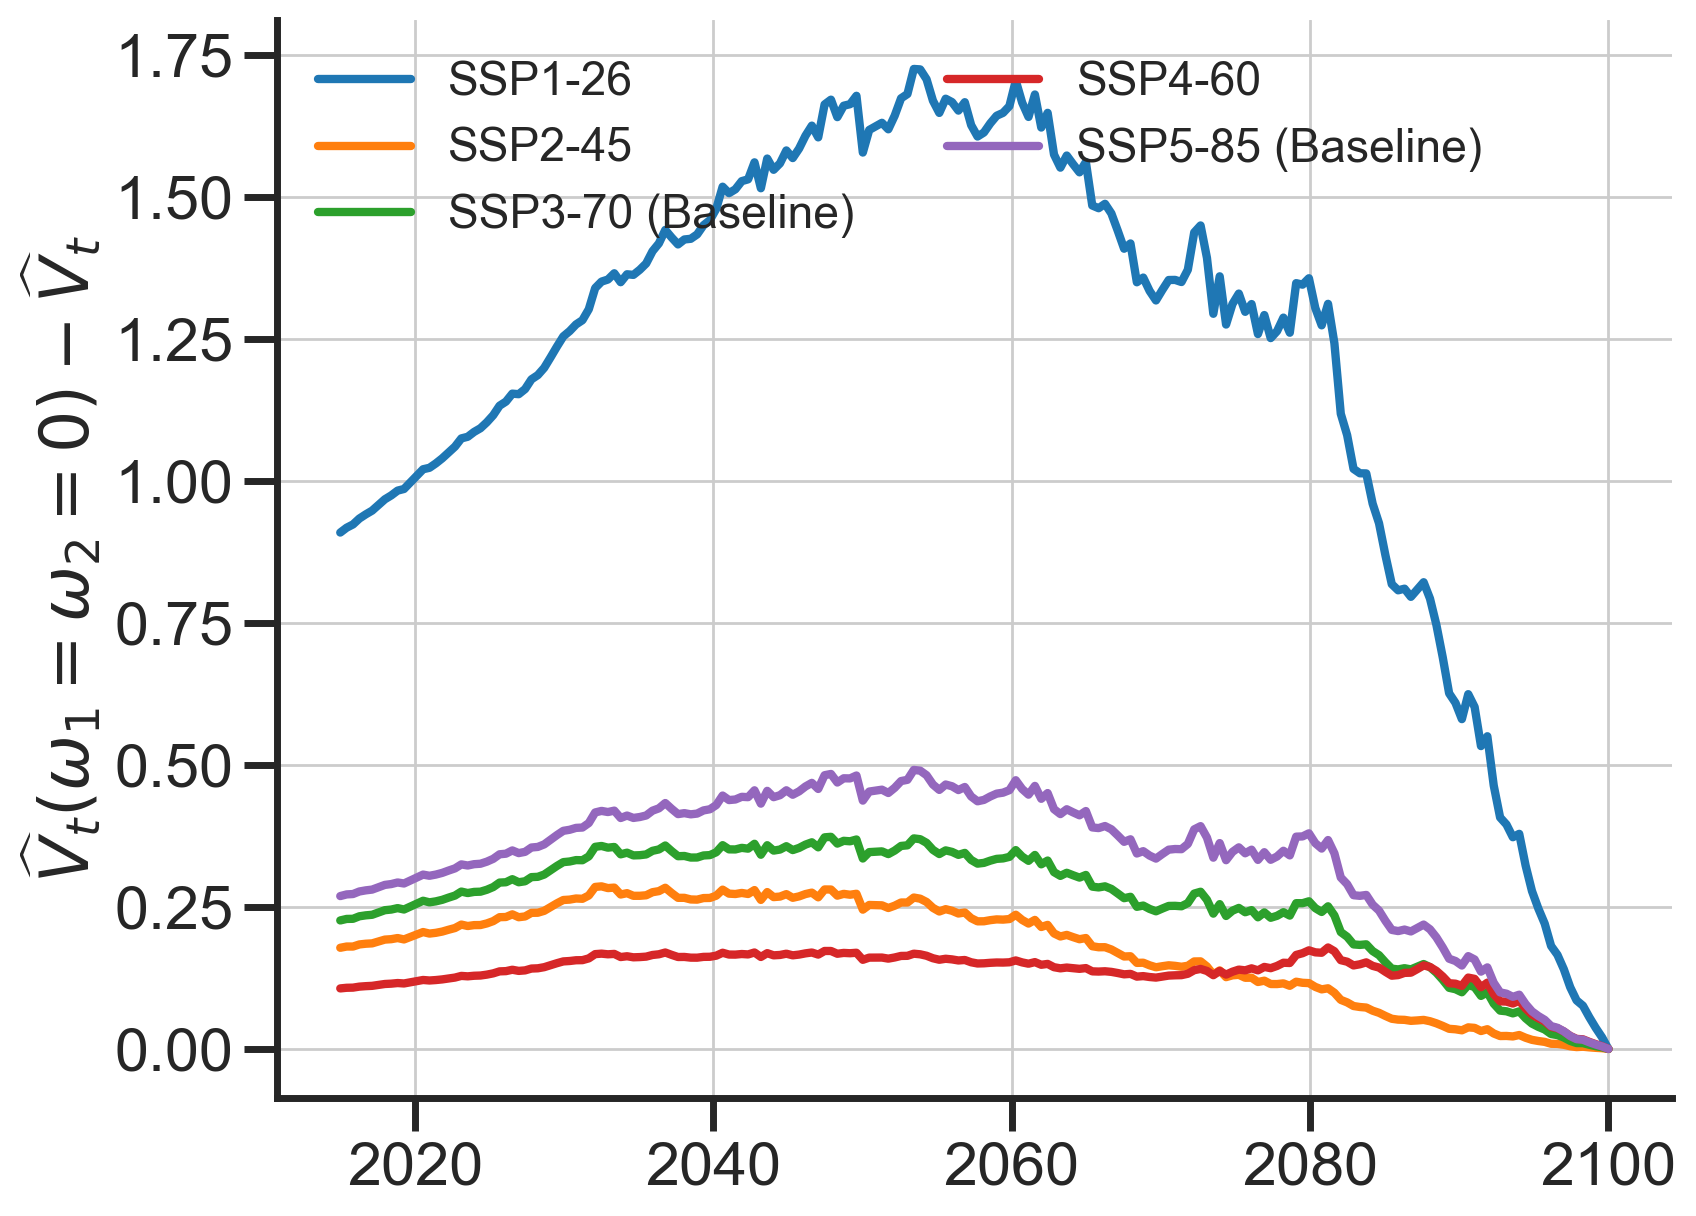

In [31]:
fig, ax = plt.subplots()
for scenario_name, value in value_dict.items():
    plt.plot(
        T_ssp_initial + tab_T,
        value_no_pen - value,
        "-",
        label=scenario_name,
    )
ax.set_ylabel("$\\widehat{V}_t(\\omega_1=\\omega_2=0) - \\widehat{V}_t$")
ax.legend(loc="upper left", ncol=2, framealpha=0)
plt.show()

### Default Probability

In [32]:
# Set default intensity
lbd_ref = 0.03
sub_time = np.linspace(1.0, 50.0, 50)

To calibrate the default boundary $L^i(t)$, we proceed as in Section 3.2 of 
the [paper](https://hal.science/hal-03458299/document).

 - Given a default intensity rate $\lambda_{\textrm{ref}}^i$ for the $i$-th obligor, 
    $L^i(t)$ is determined such that
    $$
        \mathbb{P} \left(\widehat{V}^{i}_t (\omega_1=\omega_2=0) \leq L^i(t)\right) 
        = 1 - e^{-\lambda_{\textrm{ref}}^i \, t},
    $$
    where $\widehat{V}^{i}_t (\omega_1=\omega_2=0)$ corresponds to the optimal obligor's 
    value with no reward or penalization.

In [33]:
tab_L = np.array(
    [
        Firm.default_boundary_unpenalized(
            t=t_, lbd_ref=lbd_ref, firm_no_pen=firm_no_pen
        )
        for t_ in sub_time
    ]
).flatten()

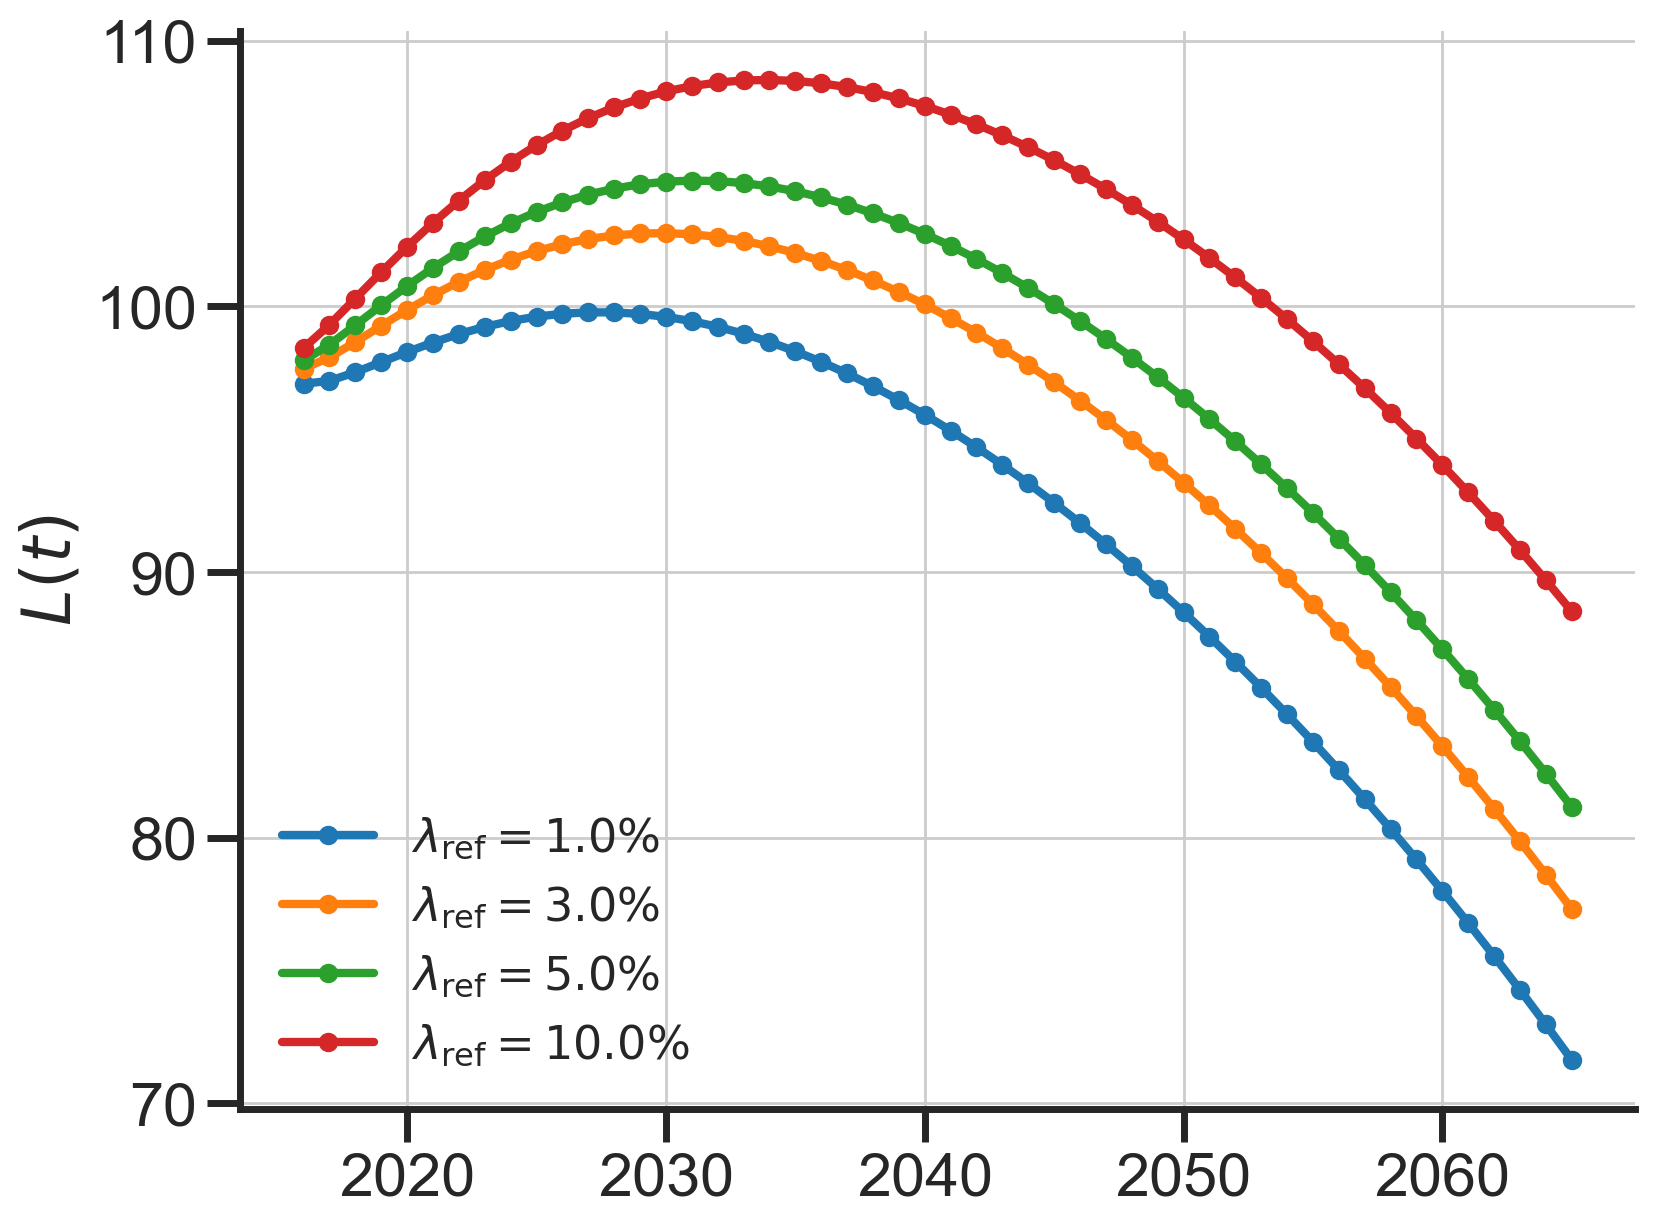

In [34]:
fig, ax = plt.subplots()
for lbd_ in [0.01, 0.03, 0.05, 0.10]:
    L_ = np.array(
        [
            Firm.default_boundary_unpenalized(
                t=t_, lbd_ref=lbd_, firm_no_pen=firm_no_pen
            )
            for t_ in sub_time
        ]
    ).flatten()
    ax.plot(
        T_ssp_initial + sub_time,
        L_,
        ".-",
        label=f"$\\lambda_{{\\mathrm{{ref}}}} = {100 * lbd_} \\% $",
    )
ax.set_ylabel("$L(t)$")
ax.legend(framealpha=0)
plt.show()

At a given time $t \ge 0$, the $i$ th obligor's probability of default 
is defined as
$$
    \mathbb{P}(\widehat{V}_t^i \le L^i(t))
$$

In [35]:
pd_dict = dict()
for scenario_name, firm in firms_dict.items():
    print(scenario_name)
    t0 = time.time()
    pd_dict[scenario_name] = np.array(
        [
            firm.proba_default_merton(
                t=t_,
                L_t=tab_L[i],
            )
            for i, t_ in enumerate(sub_time)
        ]
    ).flatten()
    t1 = time.time()
    print(f"time elapsed: {t1 - t0}")

SSP1-26
time elapsed: 0.29177093505859375
SSP2-45
time elapsed: 0.2676267623901367
SSP3-70 (Baseline)
time elapsed: 0.2677457332611084
SSP4-60
time elapsed: 0.29785680770874023
SSP5-85 (Baseline)
time elapsed: 0.26604509353637695


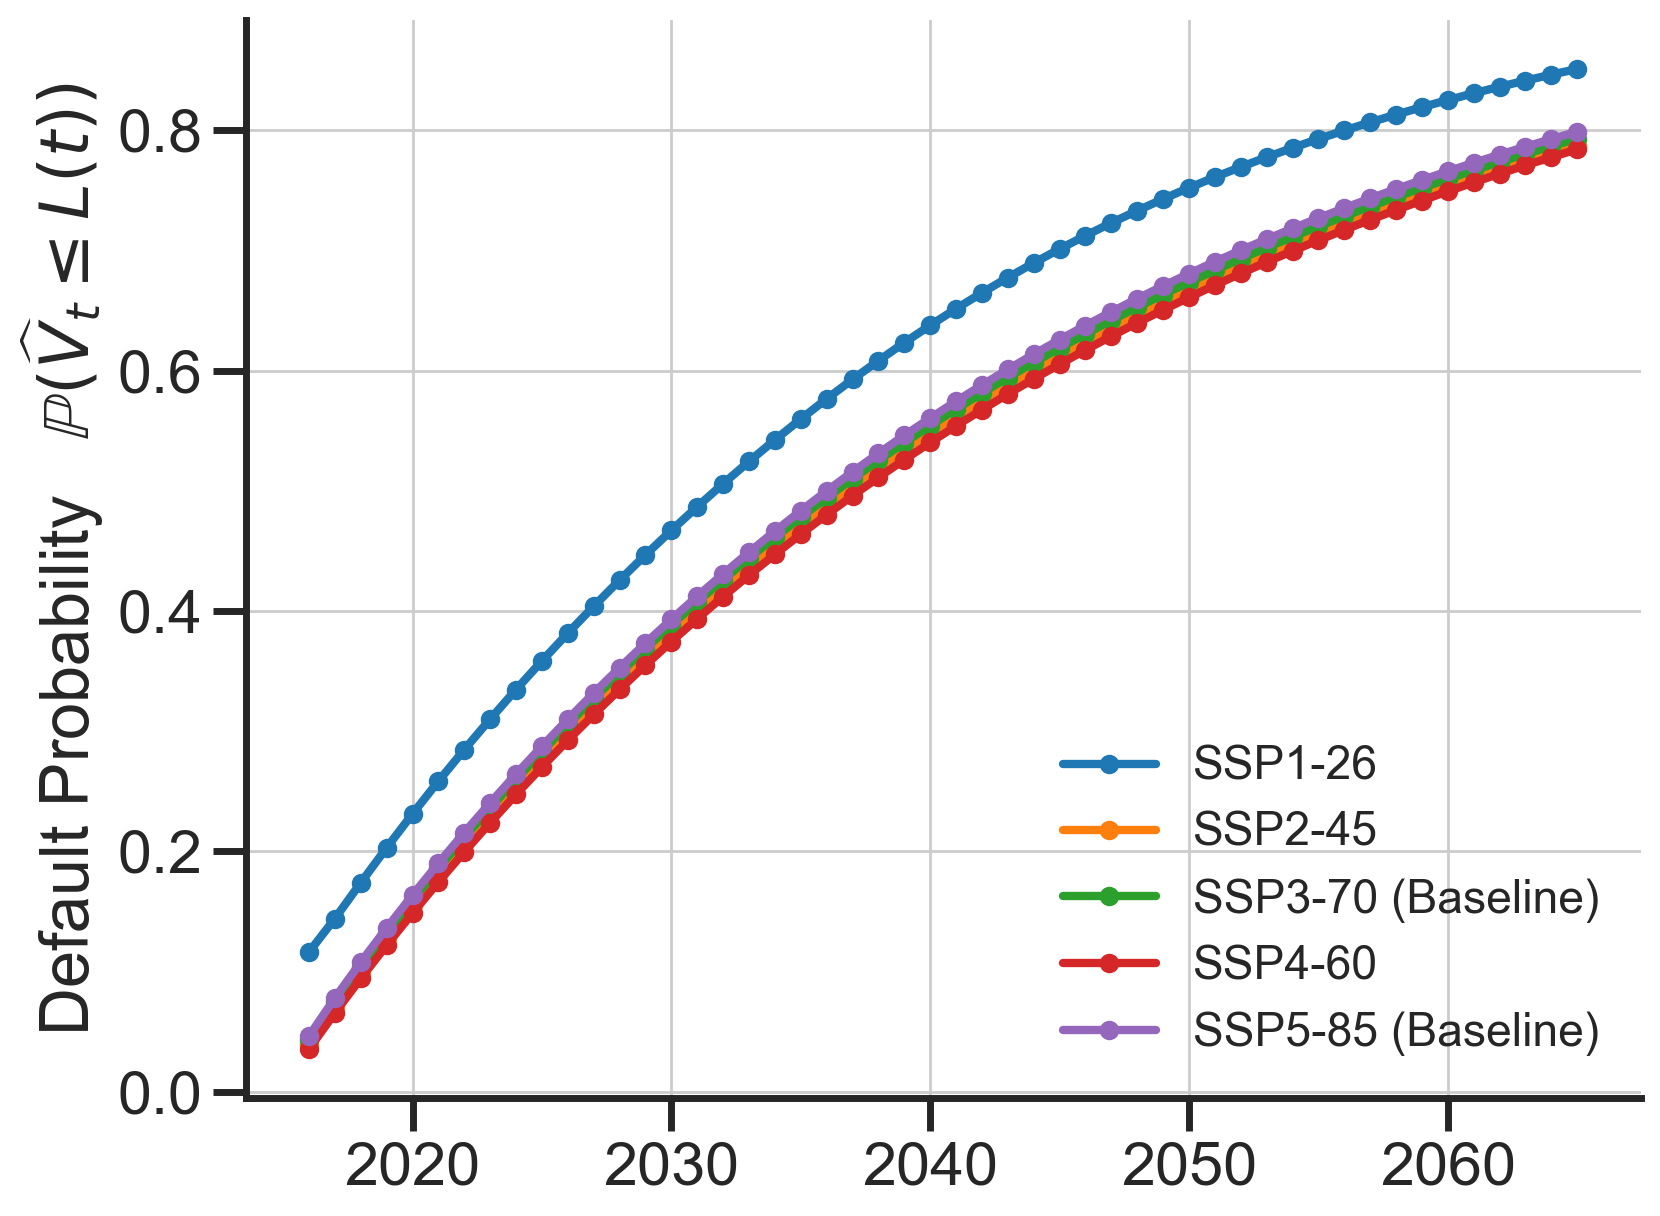

In [36]:
# Plot default probability for each scenario
fig, ax = plt.subplots()
for scenario_name, prob_default in pd_dict.items():
    ax.plot(T_ssp_initial + sub_time, prob_default, ".-", label=scenario_name)
ax.set_ylabel("Default Probability   $\\mathbb{P} (\\widehat{V}_t \\leq L(t))$")
ax.legend(loc="best", framealpha=0)
plt.show()

In [37]:
intensity_dict = {
    scenario_name_: Firm.default_intensity(
        tab_t=sub_time, prob_default=prob_default_firm
    )
    for scenario_name_, prob_default_firm in pd_dict.items()
}

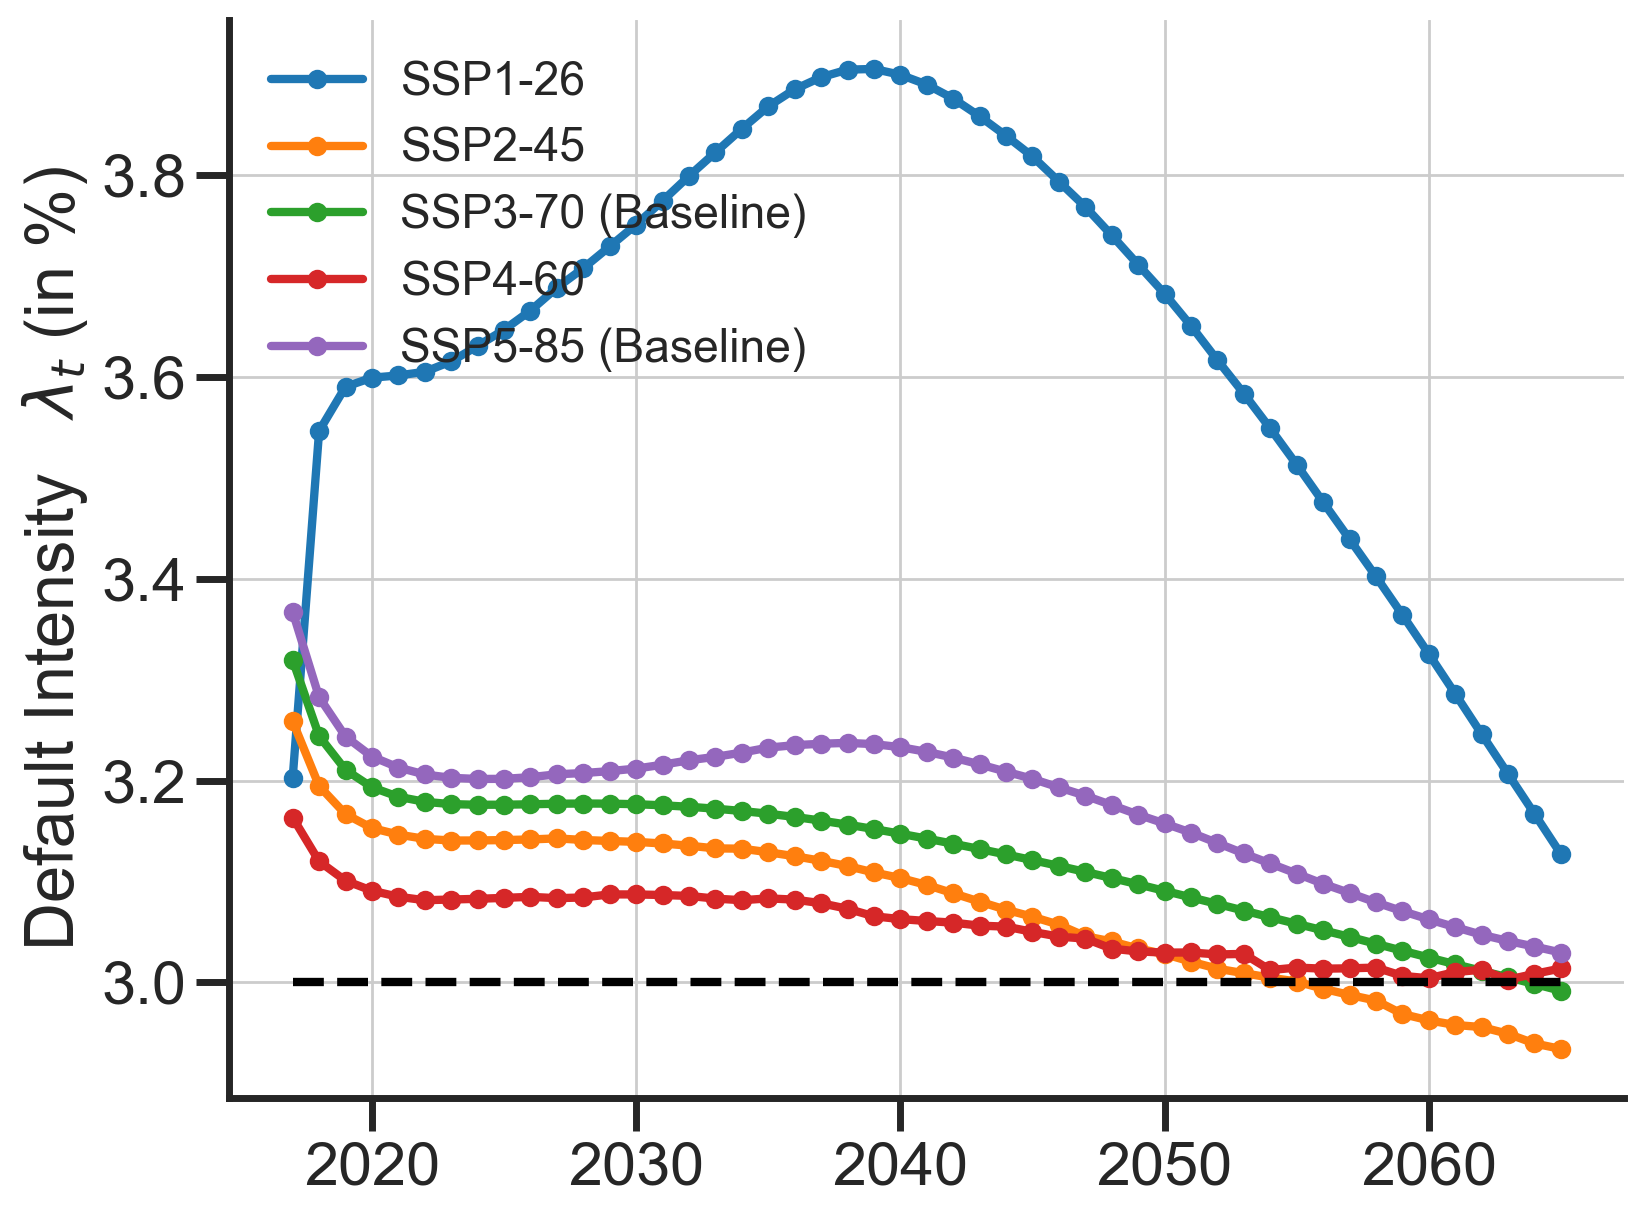

In [38]:
fig, ax = plt.subplots()
for name, intensity in intensity_dict.items():
    ax.plot(T_ssp_initial + sub_time[1:], 100 * intensity, ".-", label=name)
ax.plot(
    T_ssp_initial + sub_time[1:],
    100 * lbd_ref * np.ones_like(sub_time[1:]),
    "k--",
    # label=f"$\\lambda={100 * lbd_ref}$%",
)
ax.set_ylabel("Default Intensity   $\\lambda_t$ (in %)")
ax.legend(loc="upper left", ncol=1, framealpha=0)
plt.show()

## Portfolio of obligors

We now consider a portfolio of obligor each with its own set of parameters. 

In [39]:
np.random.seed(SEED)

# Number of firms
n_firms = 1_000
# Reference default intensity
lbd_ref = 0.03
# Portfolio loss matury
T = 5.0
P0 = 1.0

# tab_sig = 0.1 * np.ones(n_firms)
tab_sig = np.random.uniform(low=0.0, high=0.5, size=n_firms)
mat_sig = np.tile(tab_sig, (n_firms, 1))

# tab_a = 0.1 * np.ones(n_firms)
tab_a = np.random.uniform(low=0.0, high=0.5, size=n_firms)

# tab_b = tab_a = 0.1 * np.ones(n_firms)
# tab_b = np.random.uniform(low=0.0, high=1.0, size=n_firms)
tab_b = np.random.uniform(low=1.0, high=4.0, size=n_firms)
mat_b = np.tile(tab_b, (n_firms, 1))

tab_rho = np.random.uniform(-1, 1, n_firms)
mat_rho = np.tile(tab_rho, (n_firms, 1))

In [40]:
# Common parameters for each obligor
params = {
    "P0": P0,
    "r": 0.02,
    "c": np.array([0.01, 0.01, 0.01]),
    "n_units": 1,
    "w_1": 0.05,
    "w_2": 0.02,
    "alpha": np.array([0.0, 0.0, 0.0]),
    "beta": np.array([0.1, 0.5, 0.8]),
    "theta": np.array([1.0, 1.0, 1.0]),
    "T_final": T_final,
    "sector": "Transportation Sector",
}

In [41]:
# Compute Cholesky decomposition of the vector of log productions (p^i)
mat_rho_one_diag = mat_rho.copy()
mat_rho_one_diag[np.arange(n_firms), np.arange(n_firms)] = 1.0
cov_mat_p = (
    mat_sig
    * mat_sig.T
    * mat_rho_one_diag
    * mat_rho_one_diag.T
    * (1.0 - np.exp(-(mat_b + mat_b.T) * T))
    / (mat_b + mat_b.T)
)
L_chol_p = np.linalg.cholesky(cov_mat_p)

# Check that Cholesky decomposition worked
assert np.allclose(L_chol_p @ L_chol_p.T, cov_mat_p)

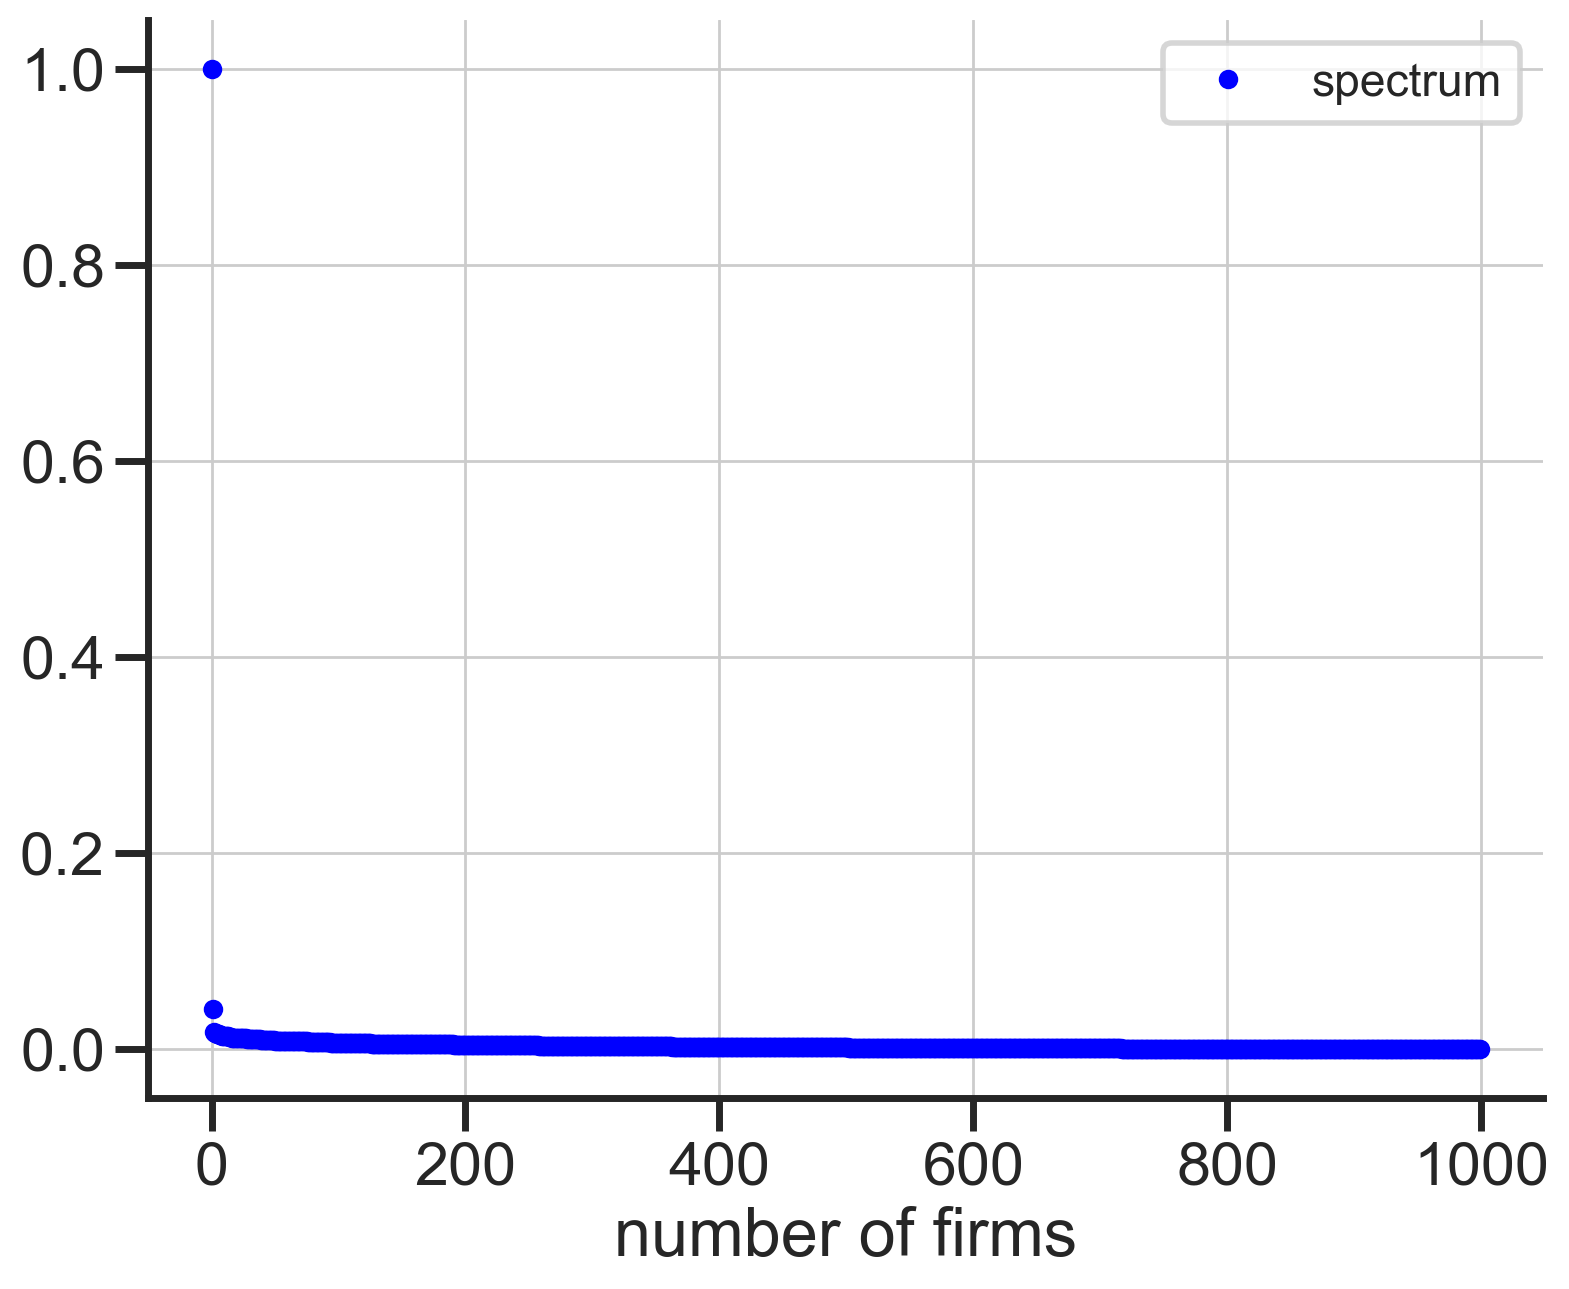

In [43]:
# Spectrum of the covariance matrix
# If the portfolio is (very) correlated, the spectrum decreases fast.

_, eigs_cov, _ = np.linalg.svd(cov_mat_p)

fig, ax = plt.subplots()
ax.plot(eigs_cov / eigs_cov[0], ".b", label="spectrum")
ax.set_xlabel("number of firms")
ax.legend()
plt.show()

### Cumulative loss of the portfolio

In [44]:
SCENARIOS

('SSP1-26', 'SSP2-45', 'SSP3-70 (Baseline)', 'SSP4-60', 'SSP5-85 (Baseline)')

In [ ]:
# Select a subset of SCENARIOS

# sub_scenarios = ("SSP1-26", "SSP3-70 (Baseline)", "SSP5-85 (Baseline)")
sub_scenarios = ("SSP1-26",)

In [ ]:
# For each scenario, we store the mean, default boundary, inverse h
# and the firm instances

mean_dict = dict()
default_boundary_dict = dict()
h_inv_L_dict = dict()
firms_dict = dict()

# Default parameters for the unpenalized firm
params_no_pen = params.copy()
params_no_pen["w_1"] = 0.0
params_no_pen["w_2"] = 0.0

for scenario in sub_scenarios:
    print(scenario)

    list_firms = []
    tab_mean_T = np.zeros(n_firms)
    tab_L_T = np.zeros(n_firms)
    tab_h_T_inv_L_T = np.zeros(n_firms)

    for i in tqdm(range(n_firms)):
        params["sig"] = tab_sig[i]
        params["a"] = tab_a[i]
        params["b"] = tab_b[i]

        params_no_pen["sig"] = tab_sig[i]
        params_no_pen["a"] = tab_a[i]
        params_no_pen["b"] = tab_b[i]

        firm = Firm(**params, scenario=scenario)
        list_firms.append(firm)
        firm_no_pen = Firm(**params_no_pen, scenario=scenario)
        tab_mean_T[i] = firm.mean_production(u=T, t=0.0)
        tab_L_T[i] = Firm.default_boundary_unpenalized(
            t=T,
            lbd_ref=lbd_ref,
            firm_no_pen=firm_no_pen,
        )[0]

        def fun(x):
            return 0.5 * (firm.h(t=T, x=x) - tab_L_T[i]) ** 2

        tab_h_T_inv_L_T[i] = optimize.minimize_scalar(fun=fun).x[0]

    mean_dict[scenario] = tab_mean_T
    default_boundary_dict[scenario] = tab_L_T
    firms_dict[scenario] = list_firms
    h_inv_L_dict[scenario] = tab_h_T_inv_L_T

SSP1-26


  0%|          | 1/1000 [00:00<02:24,  6.89it/s]

0.06384587287902832
0.06403708457946777


  0%|          | 2/1000 [00:00<02:12,  7.55it/s]

0.06352806091308594

  0%|          | 4/1000 [00:00<02:08,  7.73it/s]


0.06891727447509766
0.07571291923522949


  1%|          | 7/1000 [00:00<02:09,  7.70it/s]

0.06983304023742676
0.06491637229919434
0.0700070858001709


  1%|          | 10/1000 [00:01<02:07,  7.77it/s]

0.06925487518310547
0.0681300163269043
0.06370806694030762


  1%|▏         | 13/1000 [00:01<02:06,  7.83it/s]

0.0682830810546875
0.06966209411621094
0.06447720527648926


  2%|▏         | 16/1000 [00:02<02:04,  7.90it/s]

0.06424212455749512
0.06801199913024902
0.06364178657531738


  2%|▏         | 19/1000 [00:02<02:07,  7.68it/s]

0.06814098358154297
0.06909704208374023
0.06770801544189453


  2%|▏         | 22/1000 [00:02<02:03,  7.94it/s]

0.06802988052368164
0.06325507164001465
0.06396913528442383


  2%|▎         | 25/1000 [00:03<02:05,  7.79it/s]

0.06560778617858887
0.07064485549926758


  3%|▎         | 27/1000 [00:03<02:08,  7.57it/s]

0.06943392753601074
0.061328887939453125
0.06829571723937988


  3%|▎         | 30/1000 [00:03<02:04,  7.78it/s]

0.06826114654541016
0.06881284713745117
0.06930685043334961


  3%|▎         | 33/1000 [00:04<02:06,  7.62it/s]

0.07514500617980957
0.06912374496459961
0.06461906433105469


  4%|▎         | 36/1000 [00:04<02:08,  7.50it/s]

0.06914401054382324
0.06891918182373047
0.06413674354553223


  4%|▍         | 39/1000 [00:05<02:04,  7.72it/s]

0.06880593299865723
0.06860017776489258
0.06859683990478516


  4%|▍         | 42/1000 [00:05<02:01,  7.90it/s]

0.06876087188720703
0.06347298622131348
0.08603525161743164


  4%|▍         | 45/1000 [00:05<02:04,  7.68it/s]

0.06186795234680176
0.06893706321716309
0.0735781192779541


  5%|▍         | 48/1000 [00:06<02:03,  7.68it/s]

0.07101988792419434
0.06748390197753906


  5%|▌         | 50/1000 [00:06<02:08,  7.41it/s]

0.06888818740844727
0.06528592109680176
0.06833386421203613


  5%|▌         | 53/1000 [00:06<02:02,  7.72it/s]

0.06886816024780273
0.0676271915435791
0.06830596923828125


  6%|▌         | 56/1000 [00:07<02:00,  7.82it/s]

0.06842899322509766
0.06810879707336426
0.06934022903442383


  6%|▌         | 59/1000 [00:07<02:03,  7.59it/s]

0.06901192665100098
0.06550979614257812
0.06833004951477051


  6%|▌         | 62/1000 [00:08<02:02,  7.66it/s]

0.0688328742980957
0.06833696365356445
0.07038998603820801


  6%|▋         | 65/1000 [00:08<01:59,  7.82it/s]

0.06946301460266113
0.06325602531433105


  7%|▋         | 67/1000 [00:08<02:03,  7.54it/s]

0.06863117218017578
0.061575889587402344


  7%|▋         | 69/1000 [00:08<02:04,  7.48it/s]

0.07544183731079102
0.0711069107055664
0.06638383865356445


  7%|▋         | 72/1000 [00:09<02:02,  7.55it/s]

0.07028770446777344
0.06860208511352539
0.06838083267211914


  8%|▊         | 75/1000 [00:09<02:02,  7.54it/s]

0.06394577026367188
0.06881093978881836
0.07057785987854004


  8%|▊         | 78/1000 [00:10<02:02,  7.54it/s]

0.06918597221374512
0.07042407989501953
0.0657050609588623


  8%|▊         | 81/1000 [00:10<02:01,  7.55it/s]

0.07178688049316406
0.06897497177124023


  8%|▊         | 83/1000 [00:10<02:06,  7.27it/s]

0.09182095527648926
0.06693911552429199
0.07505297660827637


  9%|▊         | 86/1000 [00:11<02:00,  7.60it/s]

0.06459999084472656
0.06791877746582031
0.06950592994689941


  9%|▉         | 89/1000 [00:11<01:59,  7.60it/s]

0.06709623336791992
0.061331987380981445
0.06859588623046875


  9%|▉         | 92/1000 [00:12<01:57,  7.75it/s]

0.06430983543395996
0.07040119171142578
0.07122492790222168


  9%|▉         | 93/1000 [00:12<01:58,  7.65it/s]


KeyboardInterrupt: 

Different functions for $\Lambda^i$ (LGD times EAD). For example, 
$\Lambda^i=\frac{1}{\sqrt{i}}$ or $\Lambda^i=\lceil(5i/n)\rceil^2$

In [37]:
def f_Lambda(i, opt=1):
    if opt == 1:
        # homogeneous portfolio
        return 1 / np.sqrt(i)
    elif opt == 2:
        return (np.ceil(5 * i / n_firms)) ** 2
    else:
        raise ValueError("check value for opt")

In [38]:
# Precompute vector of Lambda^i
tab_Lambda = f_Lambda(np.arange(1, n_firms + 1))
# sns.histplot(tab_Lambda);

In [39]:
# Number of Monte Carlo samples
n_mc = 100_000

Some renormalized SSP scenarios for different obligors

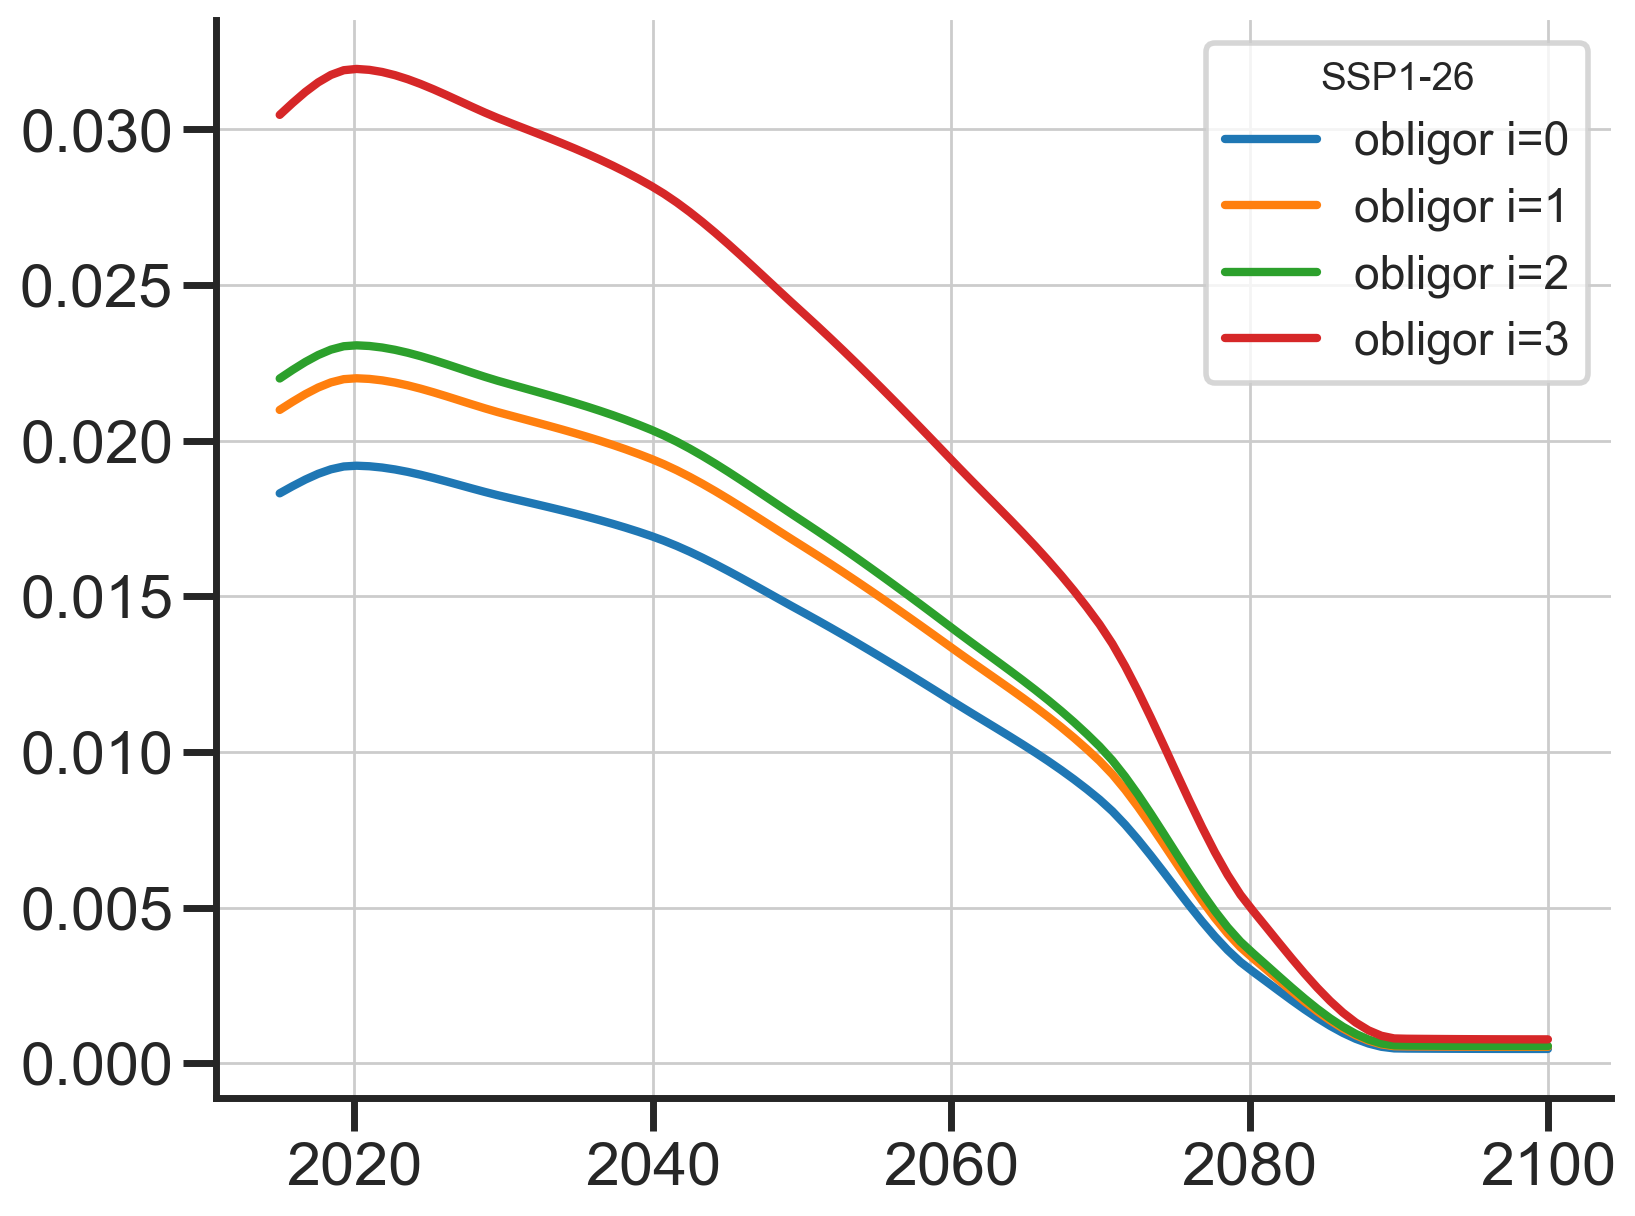

In [40]:
tab_T = np.linspace(0.0, T_final, 100)

# trajectories
fig, ax = plt.subplots()
for scenario_name in sub_scenarios[:1]:
    for i in range(4):
        _firm = firms_dict[scenario_name][i]
        ax.plot(
            T_ssp_initial + tab_T,
            _firm.f_scenario(tab_T),
            "-",
            label=f"obligor i={i}",
        )
ax.legend(title=scenario_name)
plt.show()

In [41]:
# Compute Cholesky decomposition of the covariance matrix of the vector X
cov_X = (
    (-mat_rho)
    * (-mat_rho.T)
    * (1.0 - np.exp(-(mat_b + mat_b.T) * T))
    / (mat_b + mat_b.T)
)

try:
    L_chol_X = np.linalg.cholesky(cov_X)
    print("Cholesky")
except np.linalg.LinAlgError:
    L_chol_X = utils.cholesky_from_svd(cov_X)
    print("Cholesky from SVD")

assert np.allclose(L_chol_X @ L_chol_X.T, cov_X)

Cholesky from SVD


In [42]:
# Check SVD - this might take time if n_firms is large
U, S, U_transpose = np.linalg.svd(cov_X)
S_diag = np.diag(S)

# Check SVD decomposition
assert np.allclose(U @ S_diag @ U_transpose, cov_X)

### PCA

In [43]:
# Check PCA or Spectral Decomposition. We recover the covariance matrix cov_X.
p = n_firms
cov_X_pca = np.zeros_like(cov_X)

for i in range(p):
    U_i = U[:, i].reshape(-1, 1)
    cov_X_pca += S[i] * U_i @ U_i.T

assert np.allclose(cov_X_pca, cov_X)

As $X_t \sim \mathcal{N}(0,K_{X_t})$, and $K_{X_t} = \sum_{k=1}^{n} \nu^k u^{k} (u^{k})^{\top}$, 
we can write 
$$
    X_t = \sum_{i=1}^{n} \sqrt{\nu^k} G^k u^k
$$ 
where $K_X = U \, \textrm{diag}(\nu^1,\ldots,\nu^n) \, U^T$ 
and $U = [u^1, \dots, u^n]$.

We will use a two-factor approximation
$$
    X_t \approx \sqrt{\nu^1} G^1 u^1 + \sqrt{\nu^2} G^2 u^2
$$

and the PCA approximation for the portfolio loss is given as

$$
    \mathcal{L}_{t}
    \approx
    \mathcal{L}^{\textrm{PCA}}_{t}
    :=
    \sum_{i=1}^{n}
    \Lambda^{i} \, \mathbf{1}_{ \big\{
        A_{t}^{i} \leq \sqrt{
        \nu^{1}} G^{1} u^{1, i} + \sqrt{\nu^{2}} G^{2} u^{2, i}
        \big\} }.
$$  

In [44]:
# Number of factors for the PCA approximation.
n_factors = 2

In [46]:
# Instead of doing a full SVD, it is enough to get the largest
# eigenvalues and associated eigenvectors.

_eigs_cov_X, _U_cov_X = sparse.linalg.eigs(cov_X, k=n_factors)
eigs_cov_X = np.real(_eigs_cov_X)
U_cov_X = np.real(_U_cov_X)

In [47]:
# Pre-compute parameters of vector A.
mean_A = dict()
std_A = dict()

for _scenario_name in sub_scenarios:
    print(_scenario_name)

    # Simulation of Gaussian vector A.
    std_A[_scenario_name] = np.sqrt(1.0 - tab_rho**2) * np.sqrt(
        (1.0 - np.exp(-2.0 * tab_b * T)) / (2.0 * tab_b)
    )
    mean_A[_scenario_name] = (
        np.exp(-tab_b * T) * np.log(P0)
        + mean_dict[_scenario_name]
        - h_inv_L_dict[_scenario_name]
    ) / tab_sig

SSP1-26


Sample loss $\mathcal{L}_t$ using vector of 
log productions $(\widehat{p}_t^i)_{i=1,\ldots,n}$. 

We use the representation
$$
    \mathcal{L}_t = \frac{1}{n} \sum_{i=1}^{n}
    \Lambda^i \mathbf{1}_{\widehat{p}_{t}^{i} \leq (h^i(t,\cdot))^{-1}(L^i(t))}
$$

In [48]:
np.random.seed(SEED)
loss_dict = dict()
for _scenario_name in sub_scenarios:
    print(_scenario_name)

    # simulation of log production at maturity p_T
    Z = np.random.randn(n_firms, n_mc)
    p_T = (np.exp(-tab_b * T) * np.log(P0) + mean_dict[_scenario_name])[
        :, None
    ] + L_chol_p @ Z

    # summing over all firms to get loss
    loss_dict[_scenario_name] = np.sum(
        tab_Lambda[:, None] * 1.0 * (p_T <= h_inv_L_dict[_scenario_name][:, None]),
        axis=0,
    )

SSP1-26


Sample $\mathcal{L}_{t}^{\textrm{PCA}}$ 
using vectors $A_t$ and $X_t$. Recall that 
$$
    \mathcal{L}^{\textrm{PCA}}_{t}
        :=
        \sum_{i=1}^{n}
        \Lambda^{i} \, \mathbf{1}_{ \big\{
            A_{t}^{i} \leq \sqrt{
            \nu^{1}} G^{1} u^{1, i} + \sqrt{\nu^{2}} G^{2} u^{2, i}
            \big\} }.
$$

In [49]:
np.random.seed(SEED)
loss_pca = dict()
for _scenario_name in sub_scenarios:
    print(_scenario_name)

    G_ind = np.random.randn(n_firms, n_mc)
    vec_A = mean_A[_scenario_name][:, None] + std_A[_scenario_name][:, None] * G_ind

    # PCA approximation
    vec_X_pca = np.zeros_like(vec_A)
    for k in tqdm(range(n_factors)):
        G_k = np.random.randn(n_mc)
        vec_X_pca += np.sqrt(eigs_cov_X[k]) * U_cov_X[:, k][:, None] * G_k[None, :]
    # Summing over all firms to get loss
    loss_pca[_scenario_name] = np.sum(
        tab_Lambda[:, None] * 1.0 * (vec_A <= vec_X_pca), axis=0
    )

SSP1-26


100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


In [50]:
# Sanity check with full PCA
np.random.seed(SEED)
loss_dict_check = dict()
for _scenario_name in sub_scenarios:
    print(_scenario_name)

    G_ind = np.random.randn(n_firms, n_mc)
    vec_A = mean_A[_scenario_name][:, None] + std_A[_scenario_name][:, None] * G_ind

    G = np.random.randn(n_firms, n_mc)
    vec_X = L_chol_X @ G
    loss_dict_check[_scenario_name] = np.sum(
        tab_Lambda[:, None] * 1.0 * (vec_A <= vec_X), axis=0
    )

SSP1-26


Plot of portfolio losses $\mathcal{L}$ for different scenarios

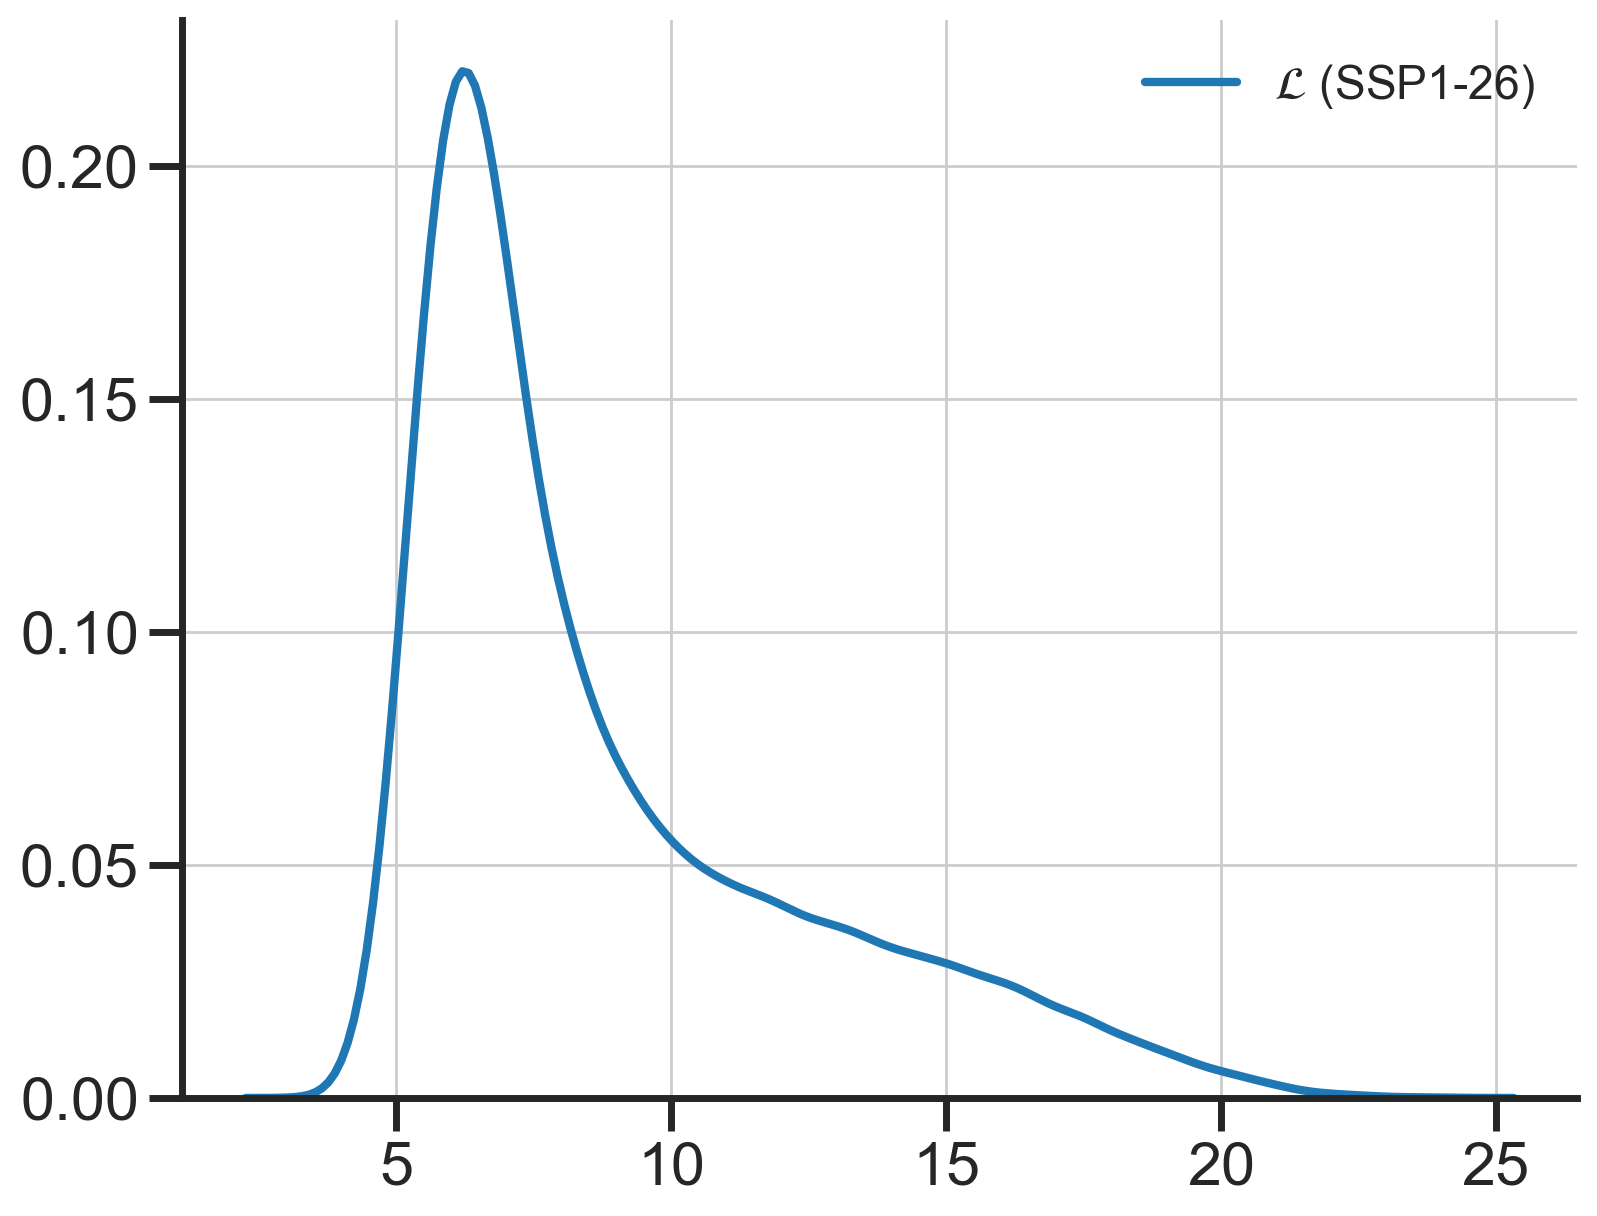

In [53]:
fig, ax = plt.subplots()
for _scenario_name in sub_scenarios:
    sns.kdeplot(
        data=loss_dict[_scenario_name],
        linestyle="-",
        label=f"$\\mathcal{{L}}$ ({_scenario_name})",
        ax=ax,
    )
    # # sanity check
    # sns.kdeplot(
    #     data=loss_dict_check[_scenario_name],
    #     linestyle="--",
    #     label=f"$\\mathcal{{L}}$ ({_scenario_name}) full PCA",
    #     ax=ax,
    # )
ax.legend(framealpha=0.0, loc="best")
ax.set_ylabel("")
# plt.savefig(f"figures/loss_T_{T}_nfirms_{n_firms}.pdf", bbox_inches="tight")
plt.show()

Plot of portfolio losses $\mathcal{L}$ with PCA approx for different scenarios

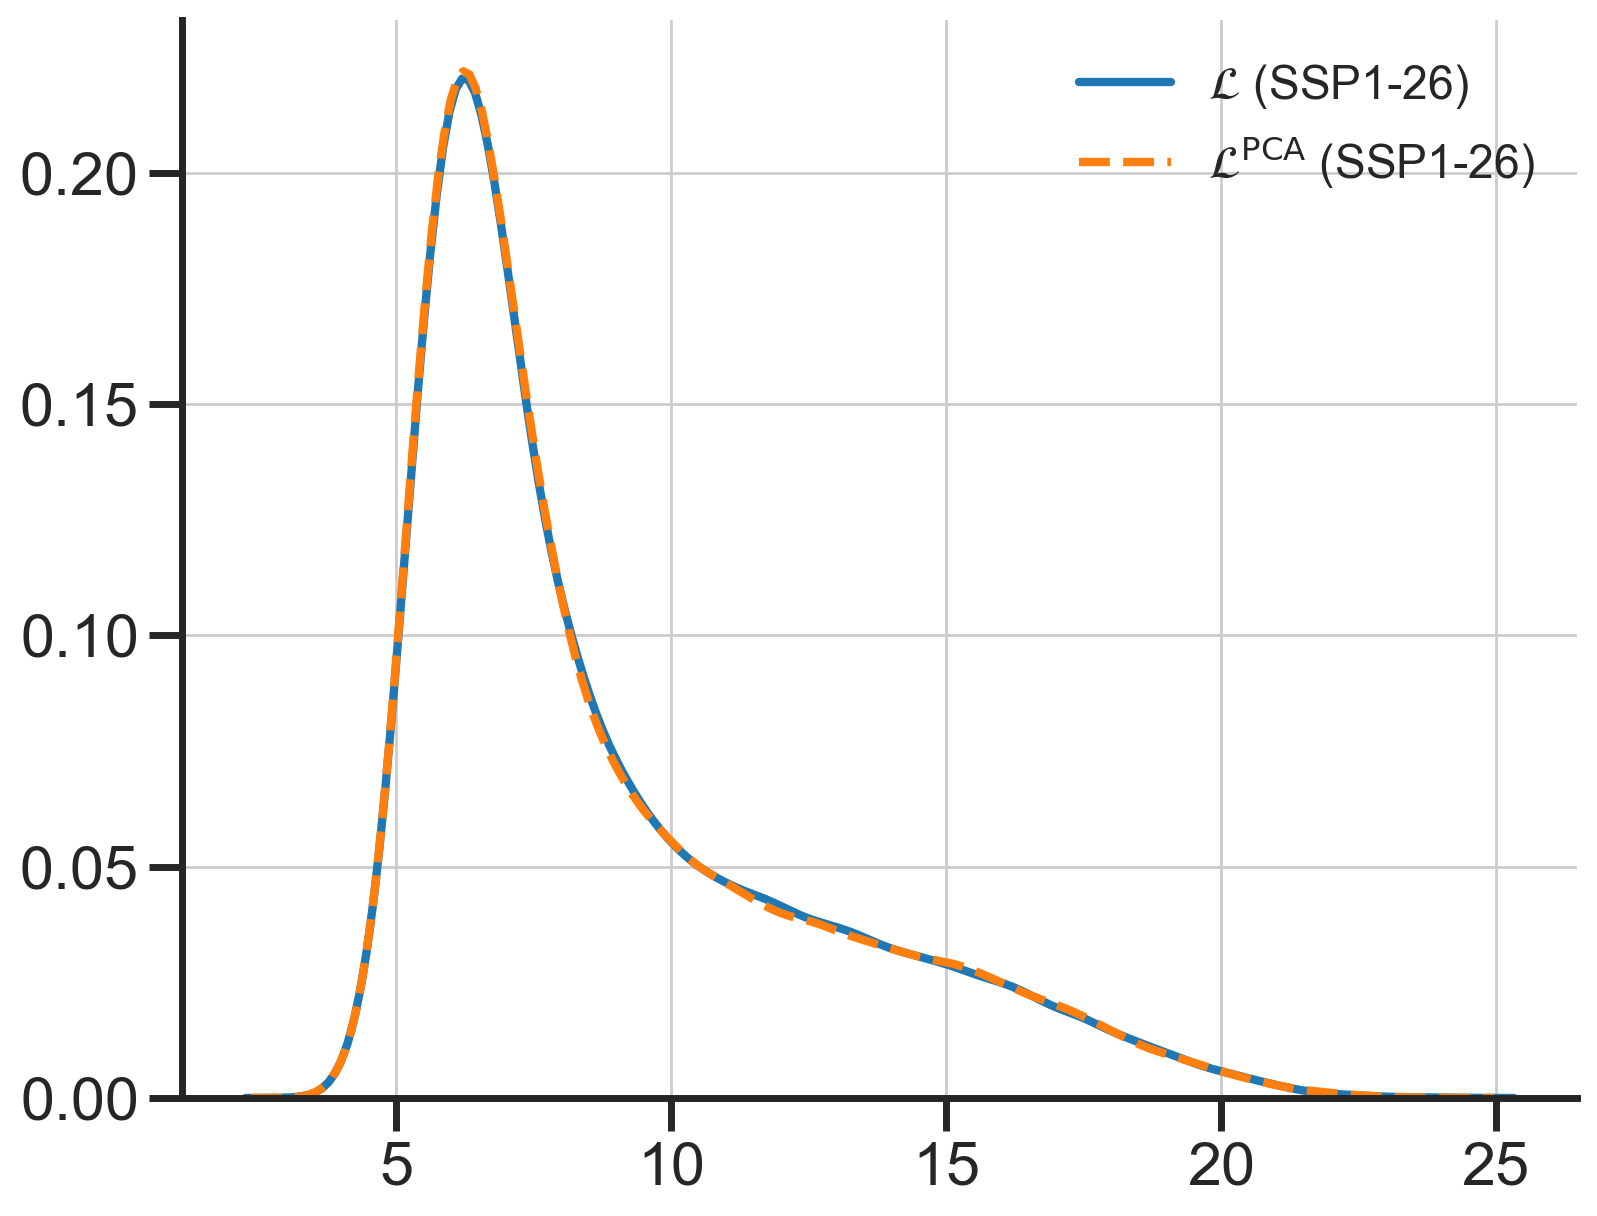

In [55]:
fig, ax = plt.subplots()
for _scenario_name in sub_scenarios:
    sns.kdeplot(
        data=loss_dict[_scenario_name],
        linestyle="-",
        label=f"$\\mathcal{{L}}$ ({_scenario_name})",
        ax=ax,
    )
for _scenario_name in sub_scenarios:
    sns.kdeplot(
        data=loss_pca[_scenario_name],
        linestyle="--",
        label=f"$\\mathcal{{L}}^{{\\mathrm{{PCA}}}}$ ({_scenario_name})",
        ax=ax,
    )
ax.legend(framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

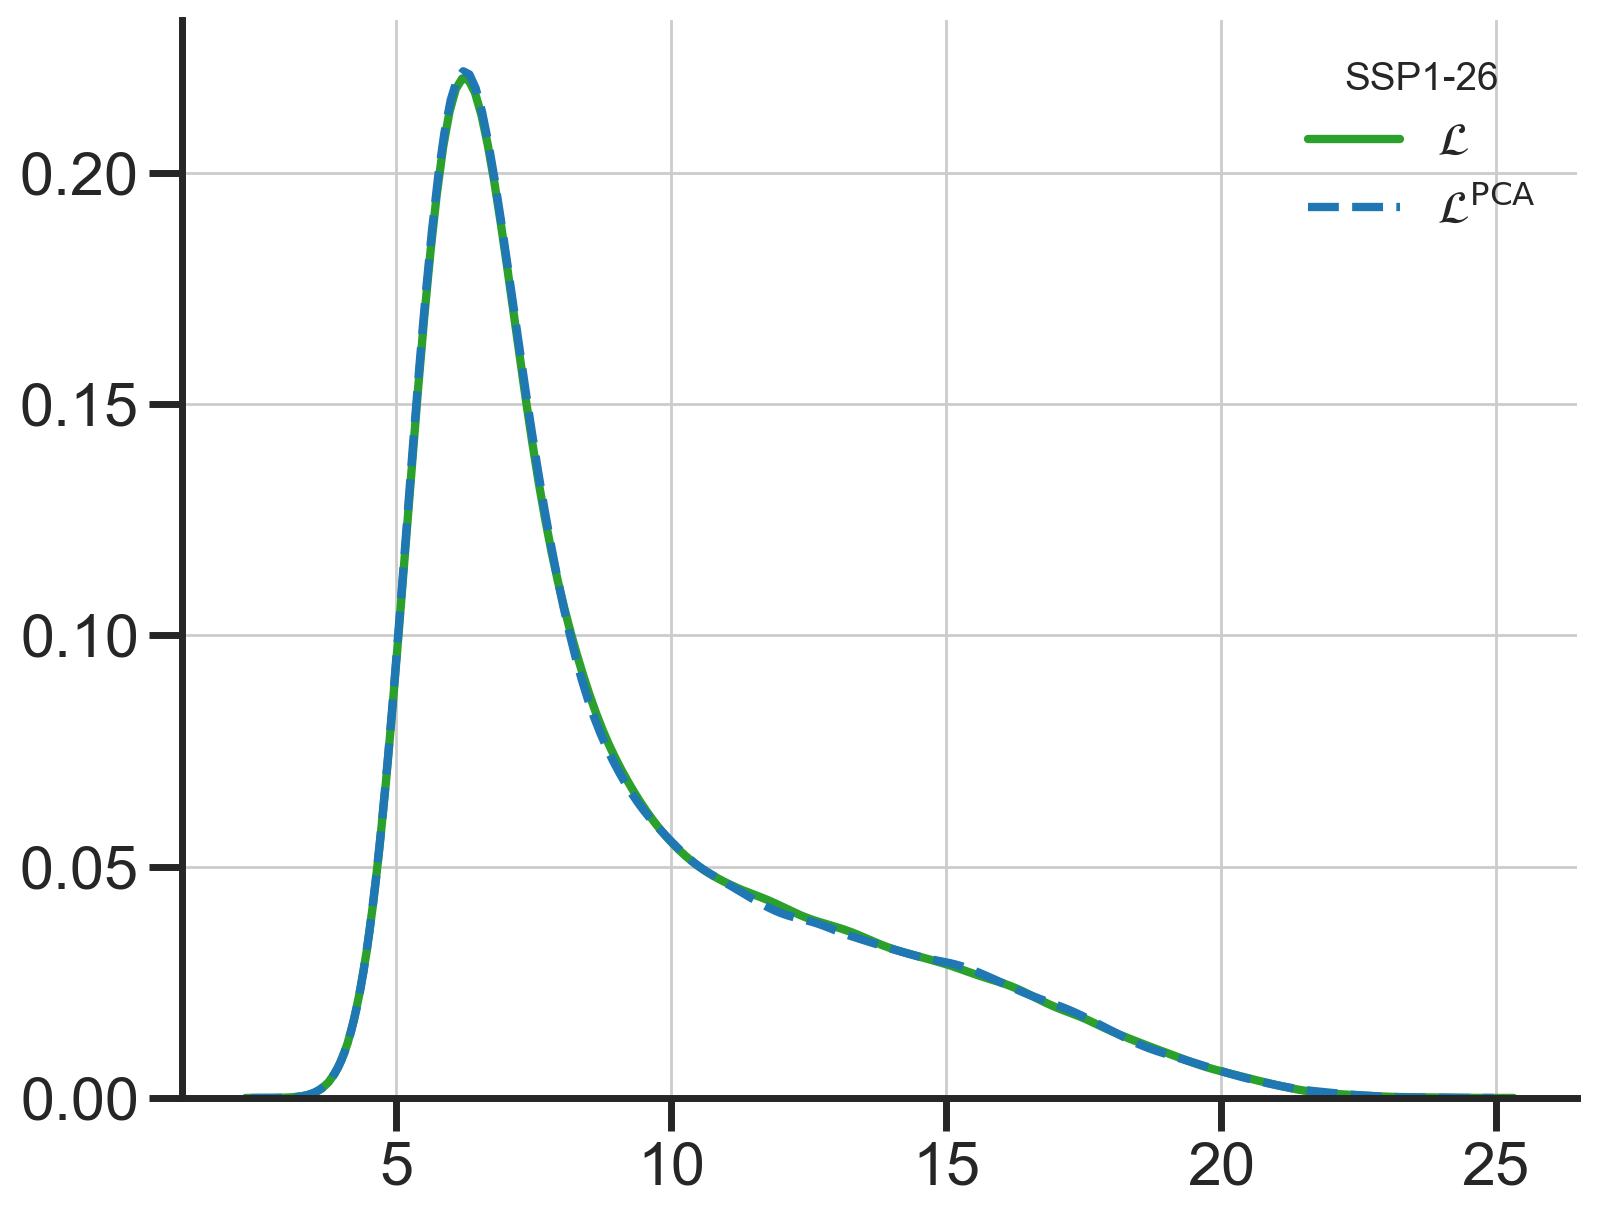

In [57]:
# Plot loss and loss-PCA for one specific scenario
_scenario_name = sub_scenarios[0]

fig, ax = plt.subplots()
sns.kdeplot(
    data=loss_dict[_scenario_name],
    linestyle="-",
    color=COLORS_SSP[_scenario_name],
    label="$\\mathcal{{L}}$",
    ax=ax,
)
sns.kdeplot(
    data=loss_pca[_scenario_name],
    linestyle="--",
    label="$\\mathcal{{L}}^{{\\mathrm{{PCA}}}}$",
    ax=ax,
)
ax.legend(title=f"{_scenario_name}", framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

Q-Q plot 

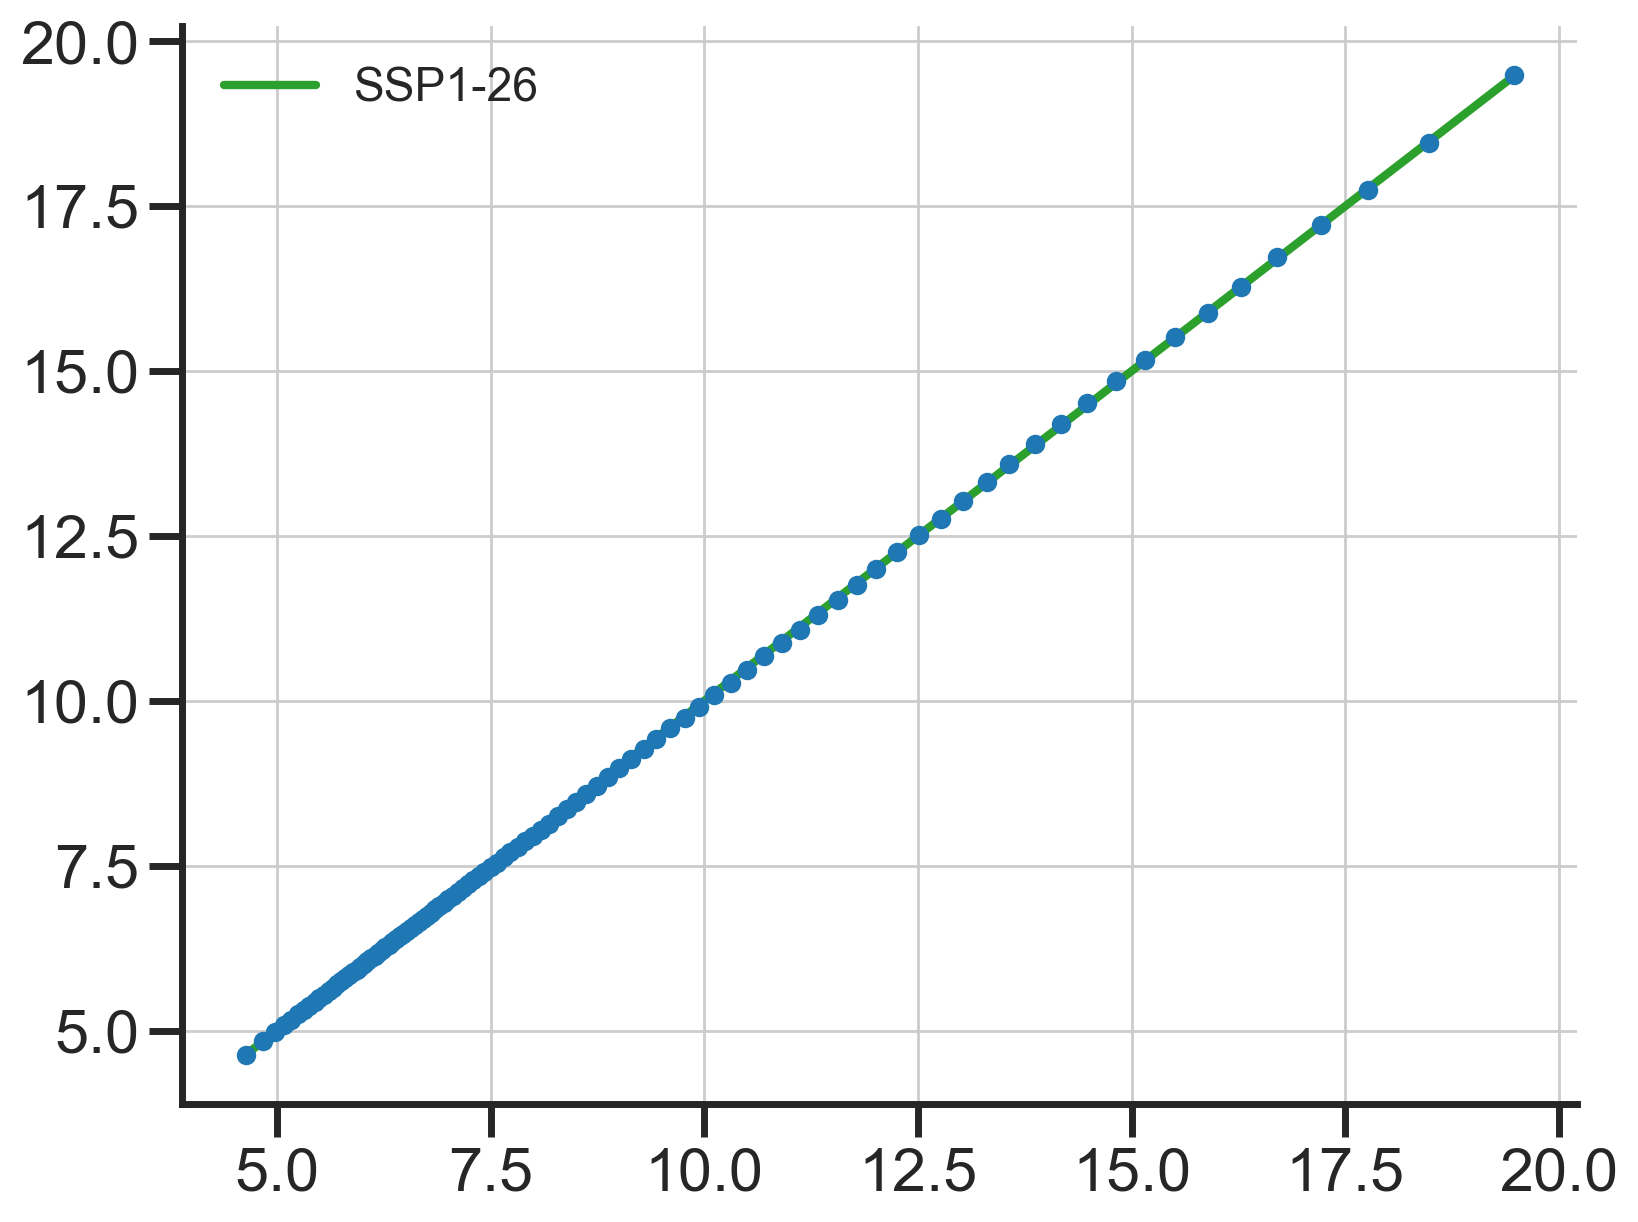

In [61]:
# Plot Q-Q plot for loss and loss-PCA for one specific scenario
_scenario_name = SCENARIOS[0]
fig, ax = plt.subplots()
tab_q = np.linspace(0.01, 0.99, 101)
quantile_loss_pca = np.quantile(loss_pca[_scenario_name], q=tab_q)
quantile_loss = np.quantile(loss_dict[_scenario_name], q=tab_q)
ax.plot(
    quantile_loss,
    quantile_loss,
    "-",
    color=COLORS_SSP[_scenario_name],
    label=f"{_scenario_name}",
)
ax.plot(quantile_loss, quantile_loss_pca, ".")
# ax.set_xlabel(r"$\mathcal{{L}}$ quantiles")
# ax.set_ylabel(r"$\mathcal{L}^{\mathrm{PCA}}$ quantiles")
ax.legend(framealpha=0)
plt.show()

### Physical Risk Impact on Portfolio Loss 

We would like to assess how physical risk is impacting the portfolio loss $\mathcal{L}_t$.

We assume that the total losses of the company is a certain percentage of the initial firm's value $V_0^i$:
$$
    \sum_{cw, l} \mathbb{E} \left[Z_{t_{ref}}^{i, cw, l}\right] \, \lambda_{t_{ref}}^{cw, l}
$$
We take $t_{ref}=0$

In [63]:
def damage_func(T_atm):
    """
    Damage function as a function of atmospheric temperature "T_atm".
    """
    a1 = 0.0
    a2 = 0.0028388
    return a1 * T_atm + a2 * T_atm**2

In [67]:
df = pd.read_csv("data/owid-ipcc-scenarios.csv")
df1 = df[["Scenario", "Year", "Temperature"]]

# SSP names used in "our-world-in-date" are slightly different than those
# from CMIP6
SCENARIOS_OWD = (
    "SSP1 - 2.6",
    "SSP2 - 4.5",
    "SSP3 - Baseline",
    "SSP4 - 6.0",
    "SSP5 - Baseline",
)
df_temp = df1[df1["Scenario"].isin(SCENARIOS_OWD)].reset_index(drop=True)
dict_names = dict()
for name_owd, name in zip(SCENARIOS_OWD, SCENARIOS):
    dict_names[name_owd] = name
df_temp["Scenario"] = df_temp["Scenario"].replace(dict_names)

In [68]:
temperature_dict = dict()
for _scenario_name in SCENARIOS:
    _df = df_temp[df_temp["Scenario"] == _scenario_name]
    _time = _df["Year"].astype(float).values[1:] - T_ssp_initial  # time starts at 2010
    _temperature = _df["Temperature"].astype(float).values[1:]
    temperature_dict[_scenario_name] = interpolate.PchipInterpolator(
        x=_time, y=_temperature
    )

We store initial values of the different firms

In [69]:
p0 = np.log(params["P0"])

V_initial_dict = dict()
for _scenario_name in sub_scenarios:
    print(_scenario_name)
    V_initial_dict[_scenario_name] = np.array(
        [_firm.h(t=0.0, x=p0) for _firm in firms_dict[_scenario_name]]
    ).flatten()

SSP1-26


In [70]:
factor = 1e-5

In [71]:
EPD_dict = dict()
for _scenario_name in sub_scenarios:
    integral_damage_temperature = integrate.quad(
        func=lambda u: np.exp(-params["r"] * (u - T))
        * damage_func(temperature_dict[_scenario_name](u)),
        a=T,
        b=T_final,
    )[0]

    integral_damage_temperature /= damage_func(temperature_dict[_scenario_name](0.0))

    EPD_dict[_scenario_name] = (
        factor * V_initial_dict[_scenario_name] * integral_damage_temperature
    )

We now compare the portfolio loss with and without EPD (physical risk term)

In [72]:
np.random.seed(SEED)

loss_dict_physical_risk = dict()
loss_dict_new = dict()

for _scenario_name in sub_scenarios:
    print(_scenario_name)

    # simulation of log production at maturity p_T
    Z = np.random.randn(n_firms, n_mc)
    p_T = mean_dict[_scenario_name][:, None] + L_chol_p @ Z

    h_T = np.array(
        [firms_dict[_scenario_name][i].h(t=T, x=p_T[i, :]) for i in range(n_firms)]
    )
    L_T = default_boundary_dict[_scenario_name]
    EPD_T = EPD_dict[_scenario_name]

    loss_dict_new[_scenario_name] = np.sum(
        tab_Lambda[:, None] * 1.0 * (h_T <= L_T[:, None]),
        axis=0,
    )

    loss_dict_physical_risk[_scenario_name] = np.sum(
        tab_Lambda[:, None] * 1.0 * (h_T <= (L_T + EPD_T)[:, None]),
        axis=0,
    )

SSP1-26


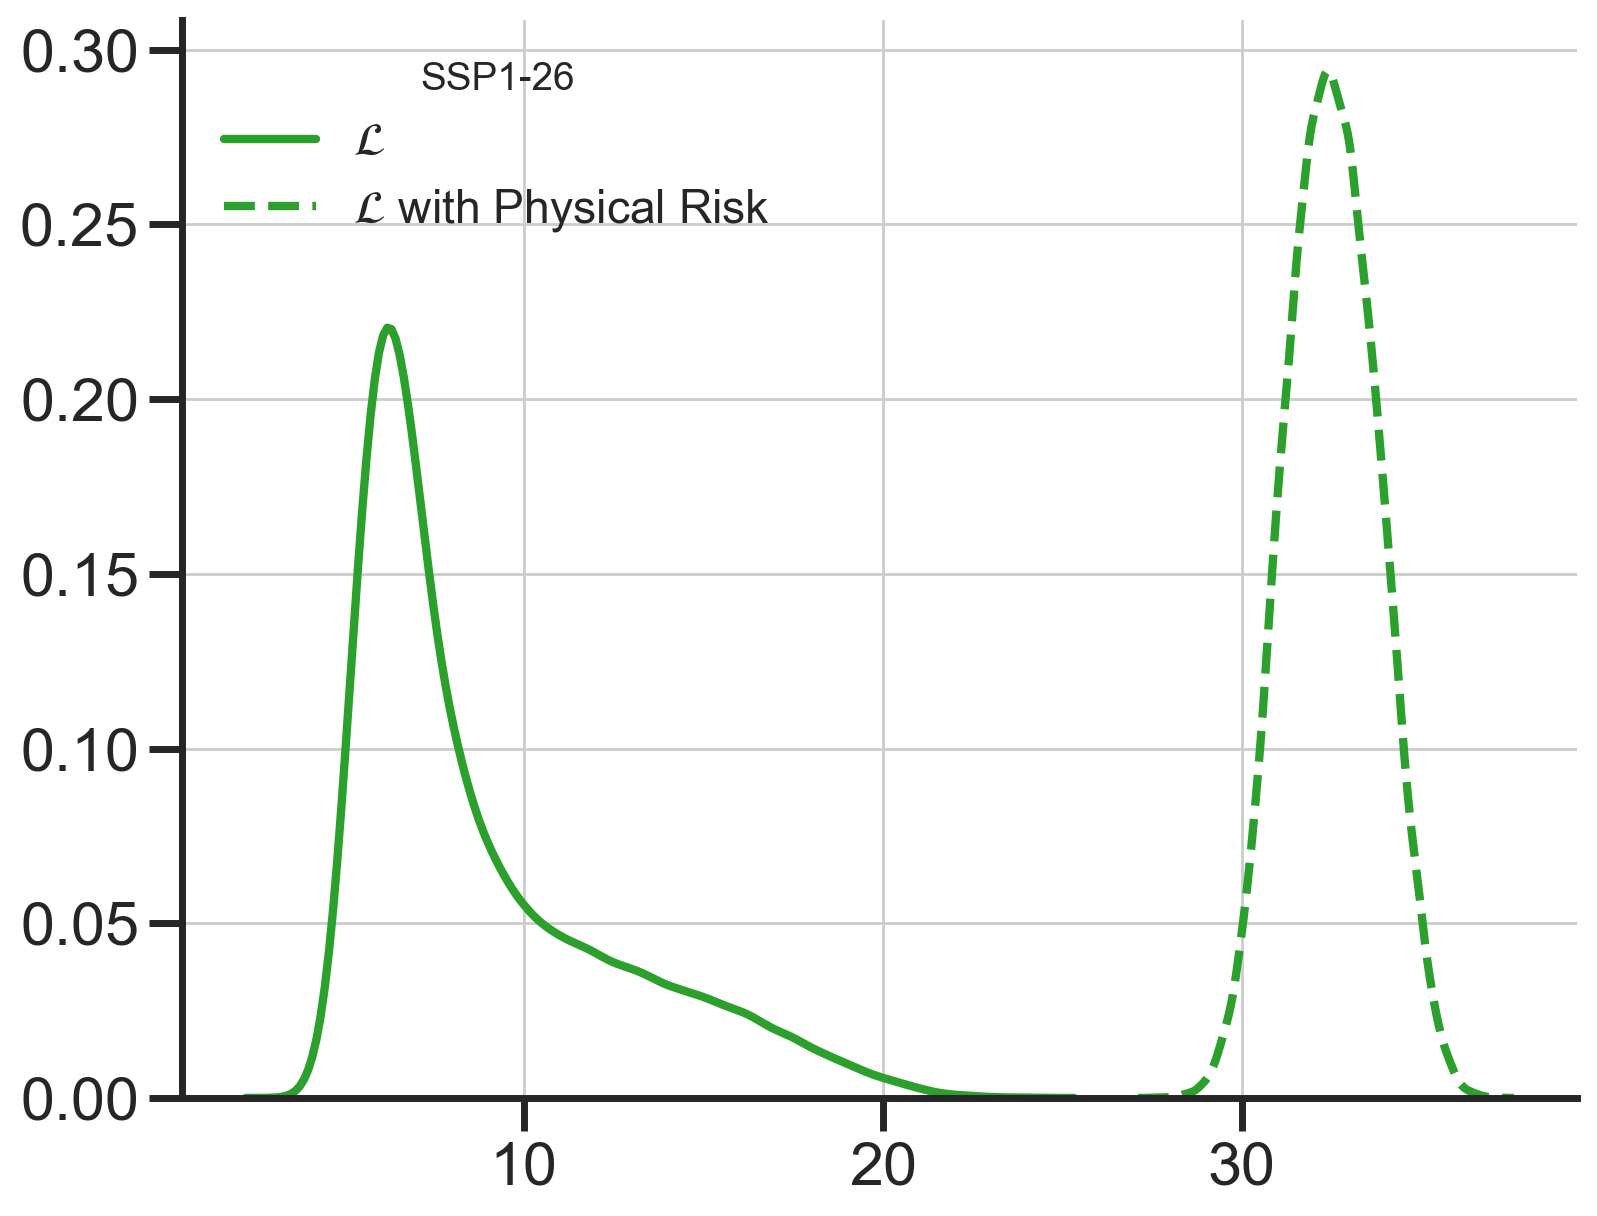

In [74]:
# Plot loss with and without physical risk term for a specific SSP
# _scenario_name = list_scenarios[1]
fig, ax = plt.subplots()
sns.kdeplot(
    data=loss_dict_new[_scenario_name],
    linestyle="-",
    color=COLORS_SSP[_scenario_name],
    label="$\\mathcal{{L}}$",
    ax=ax,
)
# sns.kdeplot(
#     data=loss_dict[_scenario_name],
#     linestyle="--",
#     color="k",
#     label=f"$\\mathcal{{L}}$ ({_scenario_name})",
#     ax=ax,
# )
sns.kdeplot(
    data=loss_dict_physical_risk[_scenario_name],
    linestyle="--",
    color=COLORS_SSP[_scenario_name],
    label="$\\mathcal{{L}}$ with Physical Risk",
    ax=ax,
)
ax.legend(title=f"{_scenario_name}", framealpha=0.0, loc="best")
ax.set_ylabel("")
plt.show()

### Polynomial Chaos Expansion 

It seems there exist some issues for the covariance matrix of the vector eps 
when M is larger than 6-8. We check that when we do not use any Gaussian approximation 
for the vector eps, we recover the true loss as M increases.

When we estimate the mean and covariance parameters by MC, there is no problem.
#TODO: correct/adapat recurrence relations.

The final PCA/PCE approximation for the portfolio loss is 
$$
    \mathcal{L}^{\textrm{PCA,PCE,G}}_{t}
    :=
    \sum_{m=0}^{M} \sum_{
    \substack{m_{1},m_{2}\geq0\\m_{1}+m_{2}=m}
    }
    \varepsilon_{n,m_{1},m_{2}}^{\mathrm{G}} \,
    \mathrm{He}_{m_{1}}(G^{1}) \, 
    \mathrm{He}_{m_{2}} (G^{2}).
$$

Pick a scenario

In [75]:
_scenario_name = sub_scenarios[0]
print(_scenario_name)

SSP1-26


In [76]:
# Pre-compute some values
L1 = np.sqrt(eigs_cov_X[0]) * U_cov_X[:, 0]
L2 = np.sqrt(eigs_cov_X[1]) * U_cov_X[:, 1]
L_norm = np.sqrt(L1**2 + L2**2)
L1_normalized = L1 / L_norm
L2_normalized = L2 / L_norm

std_A_normalized = std_A[_scenario_name] / L_norm
mean_A_normalized = mean_A[_scenario_name] / L_norm

std_A_normalized = np.float64(std_A_normalized)
mean_A_normalized = np.float64(mean_A_normalized)

In [79]:
# Checking formulas for the mean vector and covariance matrix of the PCE
M = 4

# mean/cov estimation via recursive relations
mean_A_pce = utils.mean_gauss_pce(n=M, a=std_A_normalized, b=mean_A_normalized)
_cov_A_pce = utils.cov_gauss_pce(n=2 * M, a=std_A_normalized, b=mean_A_normalized)
cov_A_pce = _cov_A_pce[: M + 1, : M + 1, :]

In [84]:
# mean/cov estimation by quadrature
mean_A_pce_quad, cov_A_pce_quad = utils.mean_cov_pce_quad(
    a=std_A_normalized, b=mean_A_normalized, n_pce=5, n_quad=40
)

In [85]:
n_pce = 5
cov_pce_quad = (
    cov_A_pce_quad
    + np.transpose(cov_A_pce_quad.copy(), axes=(1, 0, 2))
    - np.diagonal(cov_A_pce_quad).T * np.eye(n_pce + 1)[:, :, None]
)

In [86]:
# mean/cov estimation by MC
# WARNING: if n_firms is large, this might take a lot of time.

G_ind = np.random.randn(n_firms, n_mc)
vec_A = mean_A_normalized[:, None] + std_A_normalized[:, None] * G_ind
tau_vec_A_m = np.array([utils.coef_gauss_pce(n=m, x=vec_A) for m in np.arange(M + 1)])
mean_A_pce_mc = np.mean(tau_vec_A_m, axis=2)
cov_A_pce_mc = np.zeros((M + 1, M + 1, n_firms))
for i in range(n_firms):
    cov_A_pce_mc[:, :, i] = np.cov(tau_vec_A_m[:, i, :])

In [87]:
print(np.linalg.norm(mean_A_pce_quad - mean_A_pce_mc))
print(np.linalg.norm(cov_A_pce_quad - cov_A_pce_mc))

print(np.linalg.norm(mean_A_pce - mean_A_pce_mc))
print(np.linalg.norm(cov_A_pce - cov_A_pce_mc))

ValueError: operands could not be broadcast together with shapes (6,1000) (5,1000) 

In [88]:
# It might be more stable to compute the mean and cov parameters
# by a Gauss-Hermite quadrature.

In [89]:
def compute_loss_pca_pce(
    M: int,
    return_mean_cov_eps: bool = False,
    return_eps_full: bool = False,
    return_loss_full: bool = False,
    n_quad: int = 40,
) -> np.ndarray:
    """
    Compute PCA/PCE approximation for the portflio loss.
    """

    np.random.seed(SEED)

    shape_eps = int((M + 1) * (M + 2) / 2)
    tab_m1 = np.array([int(m1) for m in np.arange(M + 1) for m1 in np.arange(m + 1)])
    tab_m2 = np.array(
        [int(m2) for m in np.arange(M + 1) for m2 in reversed(np.arange(m + 1))]
    )
    tab_multi = np.array(
        [special.comb(m, m1) for m in np.arange(M + 1) for m1 in np.arange(m + 1)]
    )

    L1_normalized_m1 = np.array([L1_normalized[i] ** tab_m1 for i in range(n_firms)]).T
    L2_normalized_m2 = np.array([L2_normalized[i] ** tab_m2 for i in range(n_firms)]).T

    # mean_A_pce = utils.mean_gauss_pce(n=M, a=std_A_normalized, b=mean_A_normalized)
    # _cov_A_pce = utils.cov_gauss_pce(n=2 * M, a=std_A_normalized, b=mean_A_normalized)
    # cov_A_pce = _cov_A_pce[: M + 1, : M + 1, :]

    mean_A_pce, cov_A_pce = utils.mean_cov_pce_quad(
        a=std_A_normalized, b=mean_A_normalized, n_pce=M, n_quad=n_quad
    )

    if return_eps_full or return_loss_full:
        ### Simulating vector eps without Gaussian approximation ###
        G_ind = np.random.randn(n_firms, n_mc)
        vec_A = mean_A_normalized[:, None] + std_A_normalized[:, None] * G_ind
        tau_vec_A_m1_m2 = np.array(
            [utils.coef_gauss_pce(n=m, x=vec_A) for m in np.arange(M + 1)]
        )[tab_m1 + tab_m2, :, :]
        # Summing over all firms
        vec_eps_full = np.sum(
            tab_Lambda[None, :, None]
            * tab_multi[:, None, None]
            * tau_vec_A_m1_m2
            * L1_normalized_m1[:, :, None]
            * L2_normalized_m2[:, :, None],
            axis=1,
        )

    if return_eps_full:
        return vec_eps_full

    # Mean of the vector eps
    mean_eps = np.sum(
        tab_multi[:, None]
        * tab_Lambda[None, :]
        * mean_A_pce[tab_m1 + tab_m2, :]
        * L1_normalized_m1
        * L2_normalized_m2,
        axis=1,
    )

    # Covariance of the vector eps
    mat_m1 = np.tile(tab_m1, (shape_eps, 1))
    mat_m2 = np.tile(tab_m2, (shape_eps, 1))
    mat_m1_m2 = np.tile(tab_m1 + tab_m2, (shape_eps, 1))
    mat_L1_normalized = np.array([L1_normalized[i] ** mat_m1 for i in range(n_firms)]).T
    mat_L1_normalized_transpose = np.array(
        [L1_normalized[i] ** mat_m1.T for i in range(n_firms)]
    ).T
    mat_L2_normalized = np.array([L2_normalized[i] ** mat_m2 for i in range(n_firms)]).T
    mat_L2_normalized_transpose = np.array(
        [L2_normalized[i] ** mat_m2.T for i in range(n_firms)]
    ).T

    mat_multi = np.tile(tab_multi, (shape_eps, 1))
    cov_eps = (
        mat_multi
        * mat_multi.T
        * np.sum(
            tab_Lambda[None, None, :] ** 2
            * cov_A_pce[mat_m1_m2, mat_m1_m2.T, :]
            * mat_L1_normalized
            * mat_L2_normalized
            * mat_L1_normalized_transpose
            * mat_L2_normalized_transpose,
            axis=2,
        )
    )

    if return_mean_cov_eps:
        return mean_eps, cov_eps

    try:
        # Cholesky
        L_cov_eps = np.linalg.cholesky(cov_eps)
        Z = np.random.randn(shape_eps, n_mc)
        vec_eps = mean_eps[:, None] + L_cov_eps @ Z
    except np.linalg.LinAlgError:
        # Cholesky from SVD
        print("Cholesky from SVD")
        L_cov_eps = utils.cholesky_from_svd(cov_eps)

        # PCA decomposition
        U_cov_eps, eigs_cov_eps, _ = np.linalg.svd(cov_eps)
        vec_eps = np.zeros((eigs_cov_eps.shape[0], n_mc))
        for idx in range(shape_eps):
            Z = np.random.randn(n_mc)
            vec_eps += (
                np.sqrt(eigs_cov_eps[idx]) * U_cov_eps[:, idx][:, None] * Z[None, :]
            )
        vec_eps += mean_eps[:, None]

    Z1 = np.random.randn(n_mc)
    Z2 = np.random.randn(n_mc)
    He_m1 = np.array([special.hermitenorm(tab_m1[i])(Z1) for i in range(shape_eps)])
    He_m2 = np.array([special.hermitenorm(tab_m2[i])(Z2) for i in range(shape_eps)])
    loss_pca_pce = np.sum(vec_eps * He_m1 * He_m2, axis=0)

    if return_loss_full:
        loss_pca_pce_full = np.sum(vec_eps * He_m1 * He_m2, axis=0)
        return loss_pca_pce, loss_pca_pce_full

    return loss_pca_pce

In [196]:
# # Plot eigenvalues of the covariance matrix for the vector eps
# mean_eps, cov_eps = compute_loss_pca_pce(M=5, return_mean_cov_eps=True)
# vec_eps_full = compute_loss_pca_pce(M=5, return_eps_full=True)
# mean_eps_mc = vec_eps_full.mean()
# error = 100 * (mean_eps_mc - mean_eps) / mean_eps_mc
# print(error)
# cov_eps_mc = np.cov(vec_eps_full)
# 100 * (cov_eps_mc - cov_eps) / cov_eps_mc
# U, S, _ = np.linalg.svd(cov_eps)
# plt.plot(S, "b.");

In [90]:
M_plot = 10
loss_pca_pce = compute_loss_pca_pce(M=M_plot)
# loss_pca_pce, loss_pca_pce_full = compute_loss_pca_pce(M=M_plot, return_loss_full=True)

Cholesky from SVD


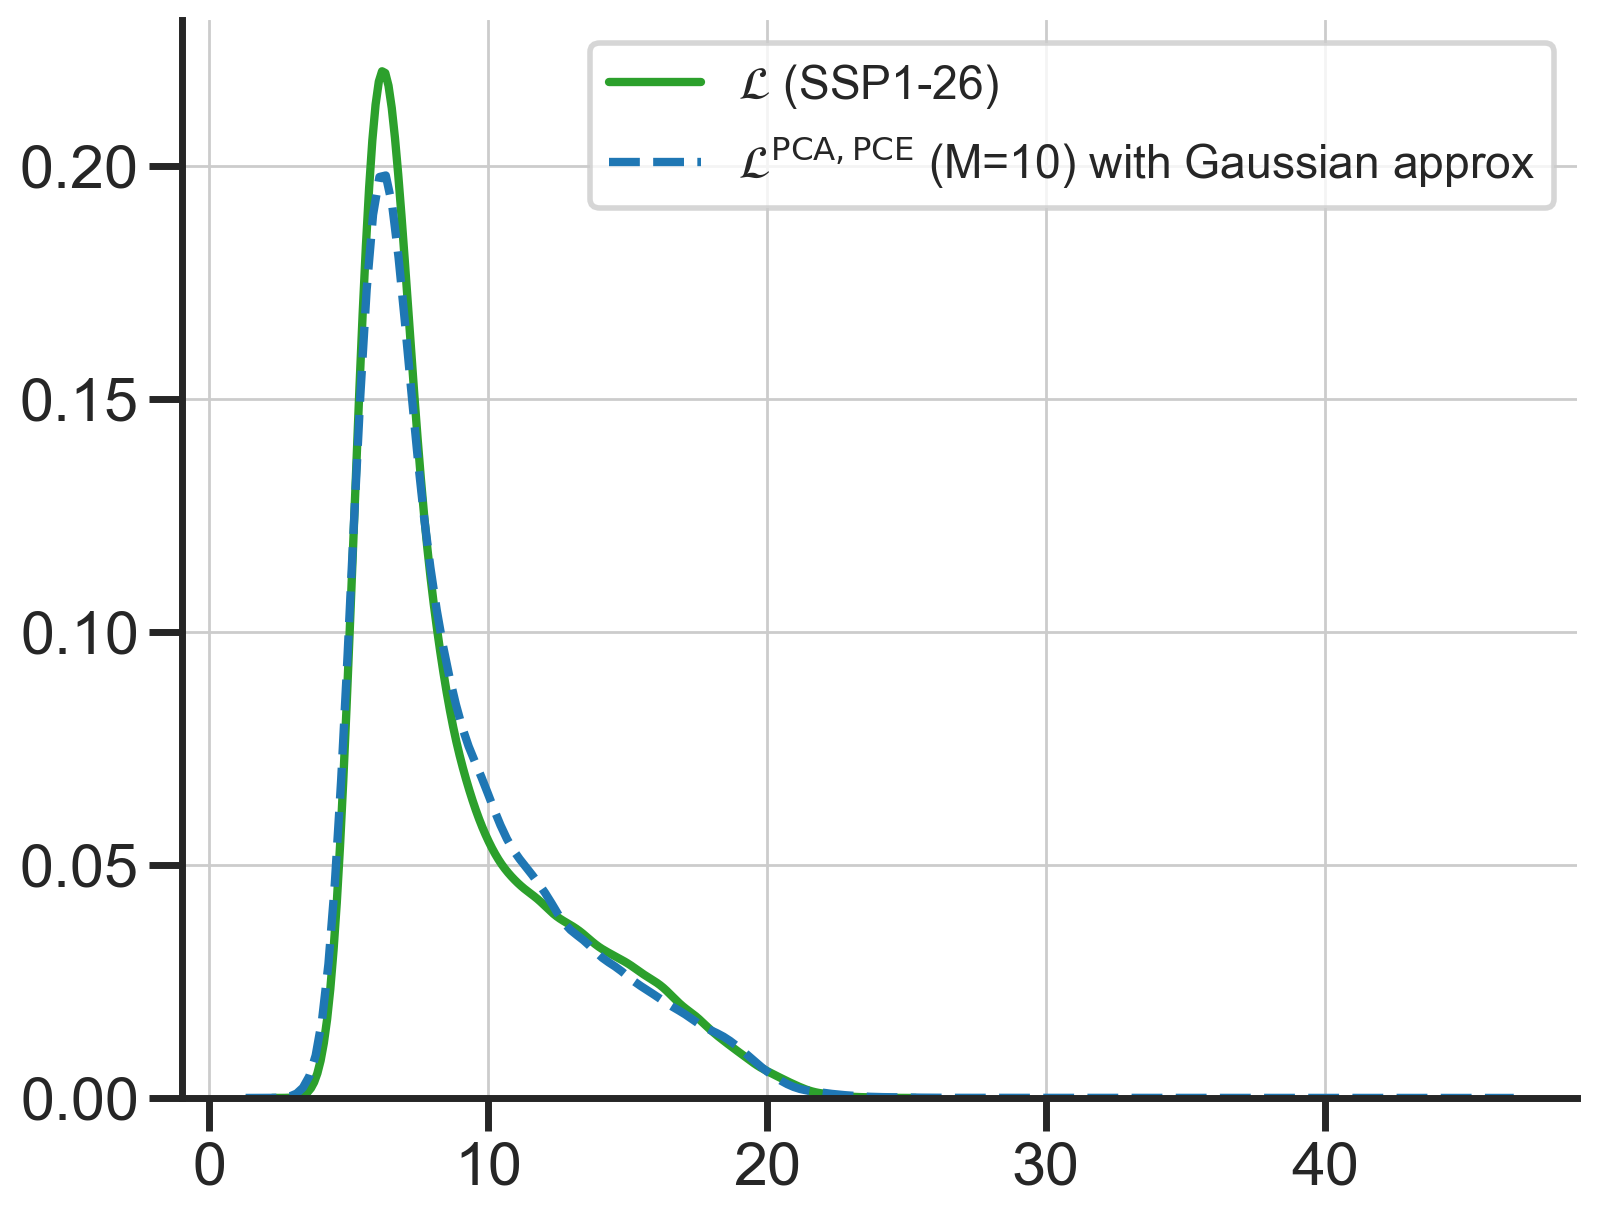

In [91]:
fig, ax = plt.subplots()
sns.kdeplot(
    loss_dict[_scenario_name],
    linestyle="-",
    color=COLORS_SSP[_scenario_name],
    label=f"$\\mathcal{{L}}$ ({_scenario_name})",
)
sns.kdeplot(
    loss_pca_pce,
    linestyle="--",
    label=f"$\\mathcal{{L}}^{{\\mathrm{{PCA,PCE}}}}$ (M={M_plot}) with Gaussian approx",
)
# sns.kdeplot(
#     loss_pca_pce_full,
#     linestyle=":",
#     label=f"$\\mathcal{{L}}^{{\\mathrm{{PCA,PCE}}}}$ (M={M_plot})",
# )
ax.legend()
ax.set_ylabel("")
plt.show()

Comparison for different truncation parameters $M$

Cholesky from SVD
Cholesky from SVD
Cholesky from SVD
Cholesky from SVD


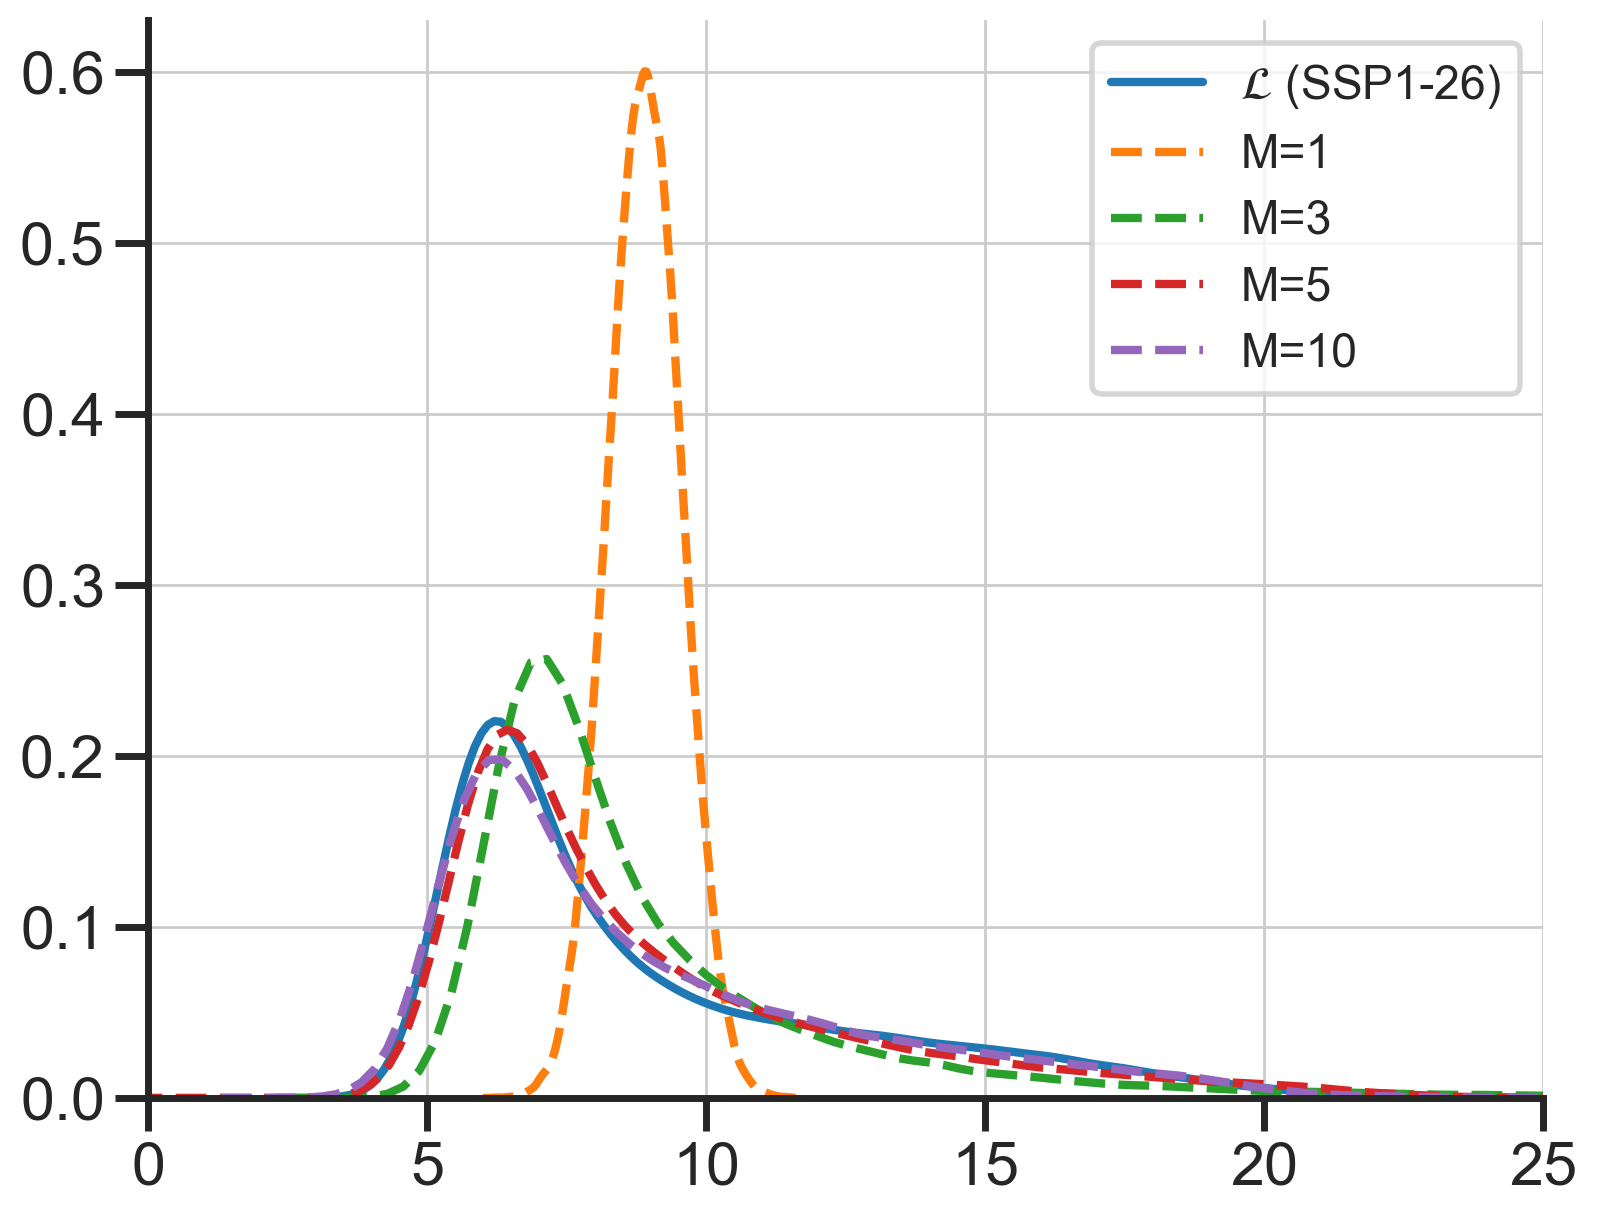

In [92]:
fig, ax = plt.subplots()
sns.kdeplot(
    loss_dict[_scenario_name],
    linestyle="-",
    # color=dict_colors_ssp[_scenario_name],
    label=f"$\\mathcal{{L}}$ ({_scenario_name})",
)

for i, M_ in enumerate([1, 3, 5, 10]):
    sns.kdeplot(compute_loss_pca_pce(M_), linestyle="--", label=f"M={M_}")
ax.legend(loc="best")
ax.set_ylabel("")
ax.set_xlim(0, 25)
plt.show()

Q-Q plot

In [93]:
tab_q = np.linspace(0.01, 0.99, 101)
quantile_loss = np.quantile(loss_dict[_scenario_name], q=tab_q)

In [94]:
M_plot = 15
loss_pca_pce = compute_loss_pca_pce(M=M_plot)
# loss_pca_pce, loss_pca_pce_full = compute_loss_pca_pce(M=M_plot, return_loss_full=True)

Cholesky from SVD


Cholesky from SVD
Cholesky from SVD
Cholesky from SVD
Cholesky from SVD


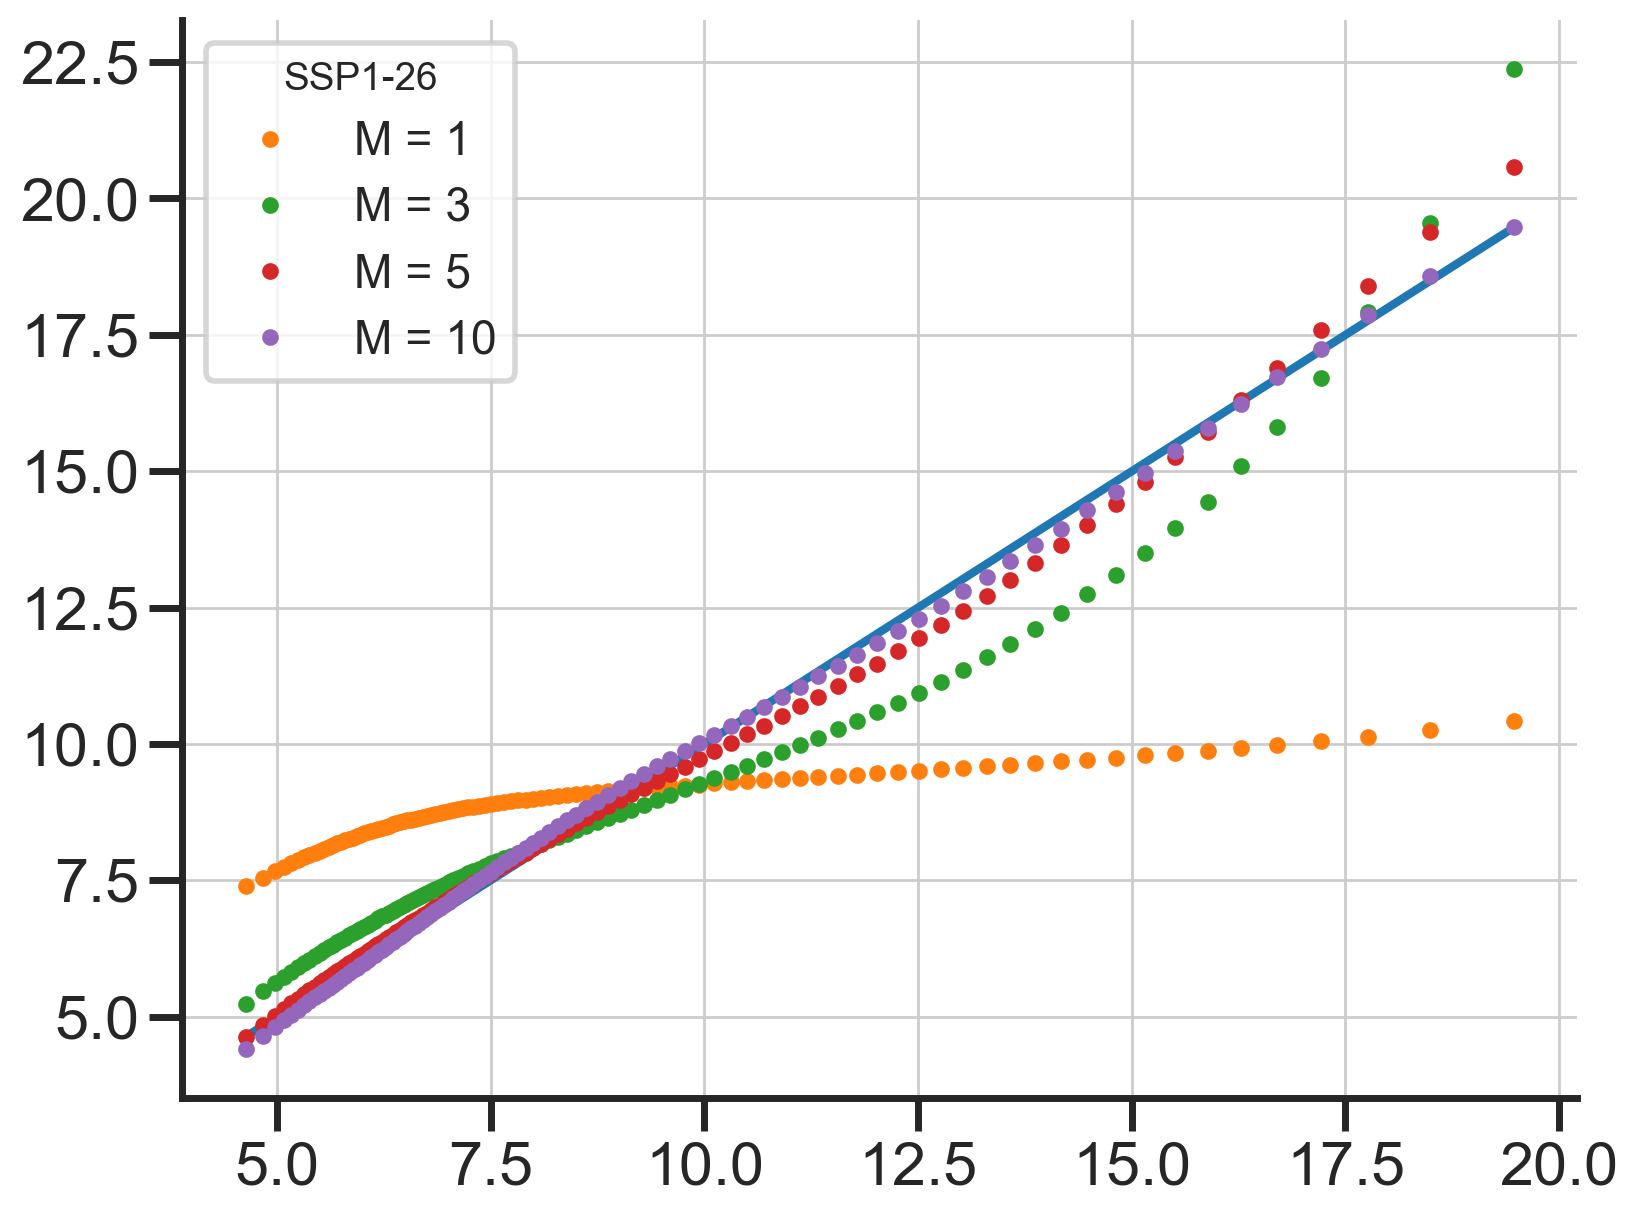

In [95]:
fig, ax = plt.subplots()
ax.plot(quantile_loss, quantile_loss, "-")

for M_ in [1, 3, 5, 10]:
    ax.plot(
        quantile_loss,
        np.quantile(compute_loss_pca_pce(M=M_), q=tab_q),
        ".",
        markersize=10,
        label=f"M = {M_}",
    )
# ax.plot(
#     quantile_loss,
#     np.quantile(loss_pca_pce_full, q=tab_q),
#     ".",
#     label=f"M = {M_plot}",
# )
# ax.set_xlabel("$\\mathcal{{L}}$ quantiles")
# ax.set_ylabel("$\\mathcal{L}^{\\mathrm{PCA,PCE}}$ quantiles")
ax.legend(title=f"{_scenario_name}")
plt.show()

# Miscellaneous

## PCA approximation

Let $K_{X_t} = (K_{X_t}^{i,j})_{1\le i,j \le n}$ be the covariance matrix 
of $X_t = (X_t^i)_{1 \leq i \leq n}$ where 
$X_t^i = -\rho^i \int_0^t e^{-b^i (t-s)} \, dB_s$.

As $X_t \sim \mathcal{N}(0,K_{X_t})$, and $K_{X_t} = \sum_{i=1}^{n} \nu^i u^{i} (u^{i})^{\top}$, 
we can write 
$$
    X_t = \sum_{i=1}^{n} \sqrt{\nu^i} G^i u^i
$$ 
where $K_{X_t} = U \, \textrm{diag}(\nu^1,\ldots,\nu^n) \, U^T$, 
$U = [u^1, \dots, u^n]$, and $(G^i)_{i=1,\ldots,n}$ iid N(0,1).

### Plot of the first largest eigenvalues $\nu^i$

In [96]:
def eig_cov_X(n, b_min, b_max, t=1.0):
    """
    Compute eigenvalues for covariance matrix X with b = Uniform[b_min, b_max]
    and the correlations rho = Uniform[-1, 1] for a given time t
    """
    b = np.random.uniform(b_min, b_max, size=n)
    b_rep = np.tile(b, (n, 1))
    rho = np.random.uniform(-1, 1, size=n)
    rho_rep = np.tile(rho, (n, 1))
    cov_X = (
        (rho_rep * rho_rep.T) * (1 - np.exp(-(b_rep + b_rep.T) * t)) / (b_rep + b_rep.T)
    )
    _, eig_X, _ = np.linalg.svd(cov_X)
    return eig_X

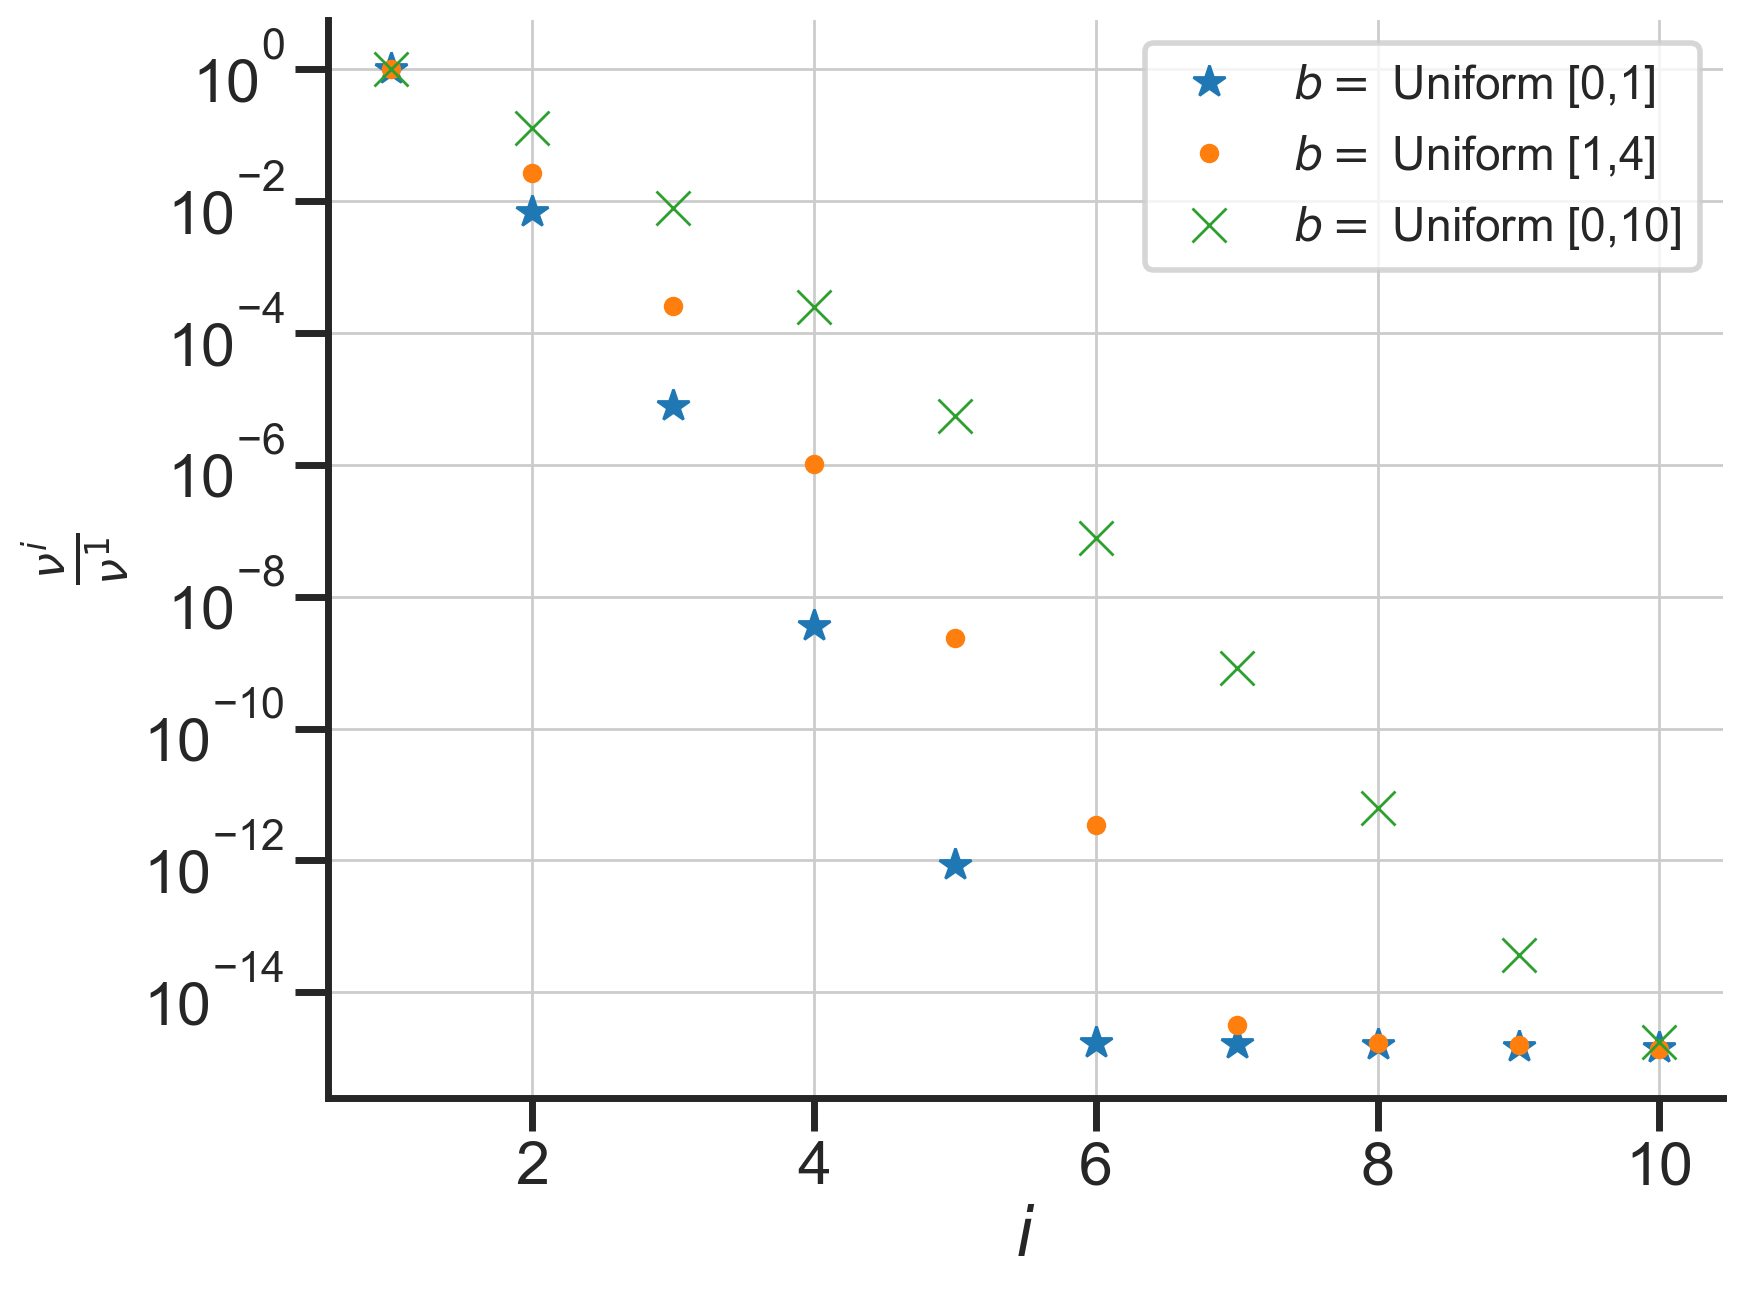

In [98]:
idx = 10
n = 1000
tab_b_min = [0, 1, 0]
tab_b_max = [1, 4, 10]
markers = ["*", ".", "x"]

fig, ax = plt.subplots()
for i, (b_min, b_max) in enumerate(zip(tab_b_min, tab_b_max)):
    eig_X_b = eig_cov_X(n=n, b_min=b_min, b_max=b_max)
    ax.plot(
        np.arange(1, idx + 1),
        eig_X_b[:idx] / eig_X_b[0],
        markers[i],
        label=f"$b=$ Uniform [{b_min},{b_max}]",
    )
ax.set_xlabel("$i$")
ax.set_ylabel(r"$\frac{\nu^{i}}{\nu^{1}}$")
ax.set_yscale("log")
ax.legend()
plt.show()

### Plots of the inertias

We plot the ratios
$$
    \frac{\nu^1}{\sum_{i=1}^{n} \nu^i}, 
    \qquad 
    \frac{\nu^1 + \nu^2}{\sum_{i=1}^{n} \nu^i}
$$
Each time, we compute 95% confidence intervals as well

In [99]:
def compute_inertia(tab_n, n_mc, b_min=0, b_max=1, t=1.0):
    """
    Compute nu_1 / sum(nu_i) and (nu_1 + nu_2) / sum(nu_1)
    where nu_i is the ith eigenvalue of the the covariance matrix X
    with b = Uniform[b_min, b_max] and correlations rho = Uniform[-1, 1]
    for a given time t. Each time, we run n_mc simulations and
    compute 95% Monte Carlo error.
    """
    list_inertia = []
    list_error = []
    for n in tqdm(tab_n):
        inertia_n_1f = np.zeros(n_mc)
        inertia_n_2f = np.zeros(n_mc)
        for i in range(n_mc):
            b = np.random.uniform(b_min, b_max, size=n)
            rho = np.random.uniform(-1, 1, size=n)
            rho_rep = np.tile(rho, (n, 1))
            b_rep = np.tile(b, (n, 1))
            cov_X = (
                (rho_rep * rho_rep.T)
                * (1 - np.exp(-(b_rep + b_rep.T) * t))
                / (b_rep + b_rep.T)
            )
            eig_X, _ = sparse.linalg.eigs(cov_X, k=2)
            eig_X = np.real(eig_X)
            eig_sum = np.trace(cov_X)
            inertia_n_1f[i] = eig_X[0] / eig_sum
            inertia_n_2f[i] = (eig_X[0] + eig_X[1]) / eig_sum

        mean_1f = np.mean(inertia_n_1f)
        mean_2f = np.mean(inertia_n_2f)
        list_inertia.append([mean_1f, mean_2f])

        err_1f = 1.96 * np.std(inertia_n_1f) / np.sqrt(n_mc)
        err_2f = 1.96 * np.std(inertia_n_2f) / np.sqrt(n_mc)
        list_error.append([err_1f, err_2f])

    inertia = np.array(list_inertia)
    error = np.array(list_error)

    return inertia, error

In [100]:
t = 1.0
tab_n = np.arange(100, 1500, 100)
n_mc = 30

In [101]:
inertia_b01, error_b01 = compute_inertia(tab_n=tab_n, n_mc=n_mc, b_min=0, b_max=1, t=t)
inertia_b14, error_b14 = compute_inertia(tab_n=tab_n, n_mc=n_mc, b_min=1, b_max=4, t=t)
inertia_b010, error_b010 = compute_inertia(
    tab_n=tab_n, n_mc=n_mc, b_min=0, b_max=10, t=t
)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


In [103]:
markersize = 10
elinewidth = 1
capsize = 3

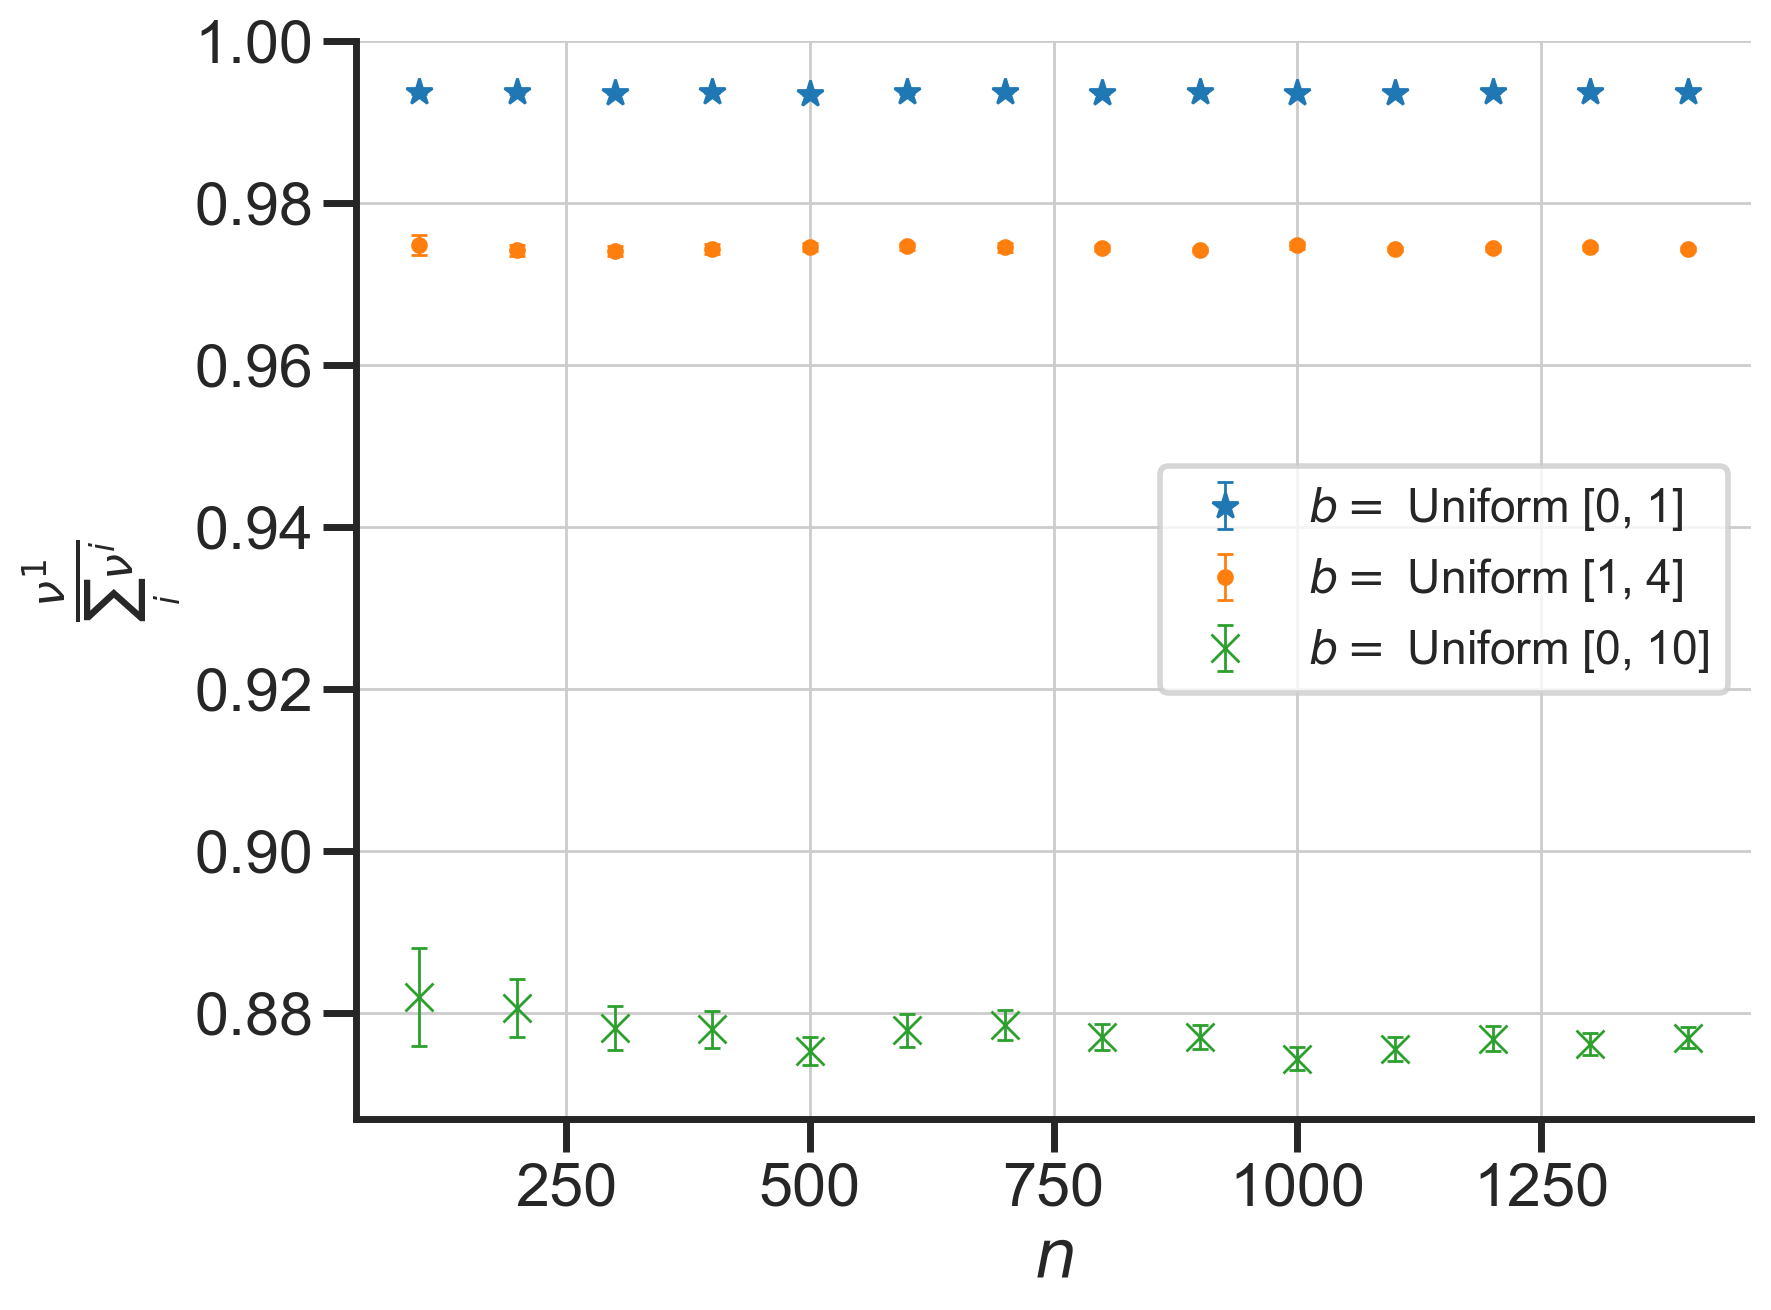

In [104]:
# with one factor
fig, ax = plt.subplots()
ax.errorbar(
    tab_n,
    inertia_b01[:, 0],
    yerr=error_b01[:, 0],
    markersize=markersize,
    elinewidth=elinewidth,
    fmt="*",
    capsize=capsize,
    label="$b=$ Uniform [0, 1]",
)
ax.errorbar(
    tab_n,
    inertia_b14[:, 0],
    yerr=error_b14[:, 0],
    markersize=markersize,
    elinewidth=elinewidth,
    fmt=".",
    capsize=capsize,
    label="$b=$ Uniform [1, 4]",
)
ax.errorbar(
    tab_n,
    inertia_b010[:, 0],
    yerr=error_b010[:, 0],
    markersize=markersize,
    elinewidth=elinewidth,
    fmt="x",
    capsize=capsize,
    label="$b=$ Uniform [0, 10]",
)
ax.set_xlabel("$n$")
ax.set_ylabel(r"$\frac{\nu^1}{\sum_{i} \nu^i}$")
ax.legend()
# ax.set_ylim(0.87, 1.0)
plt.show()

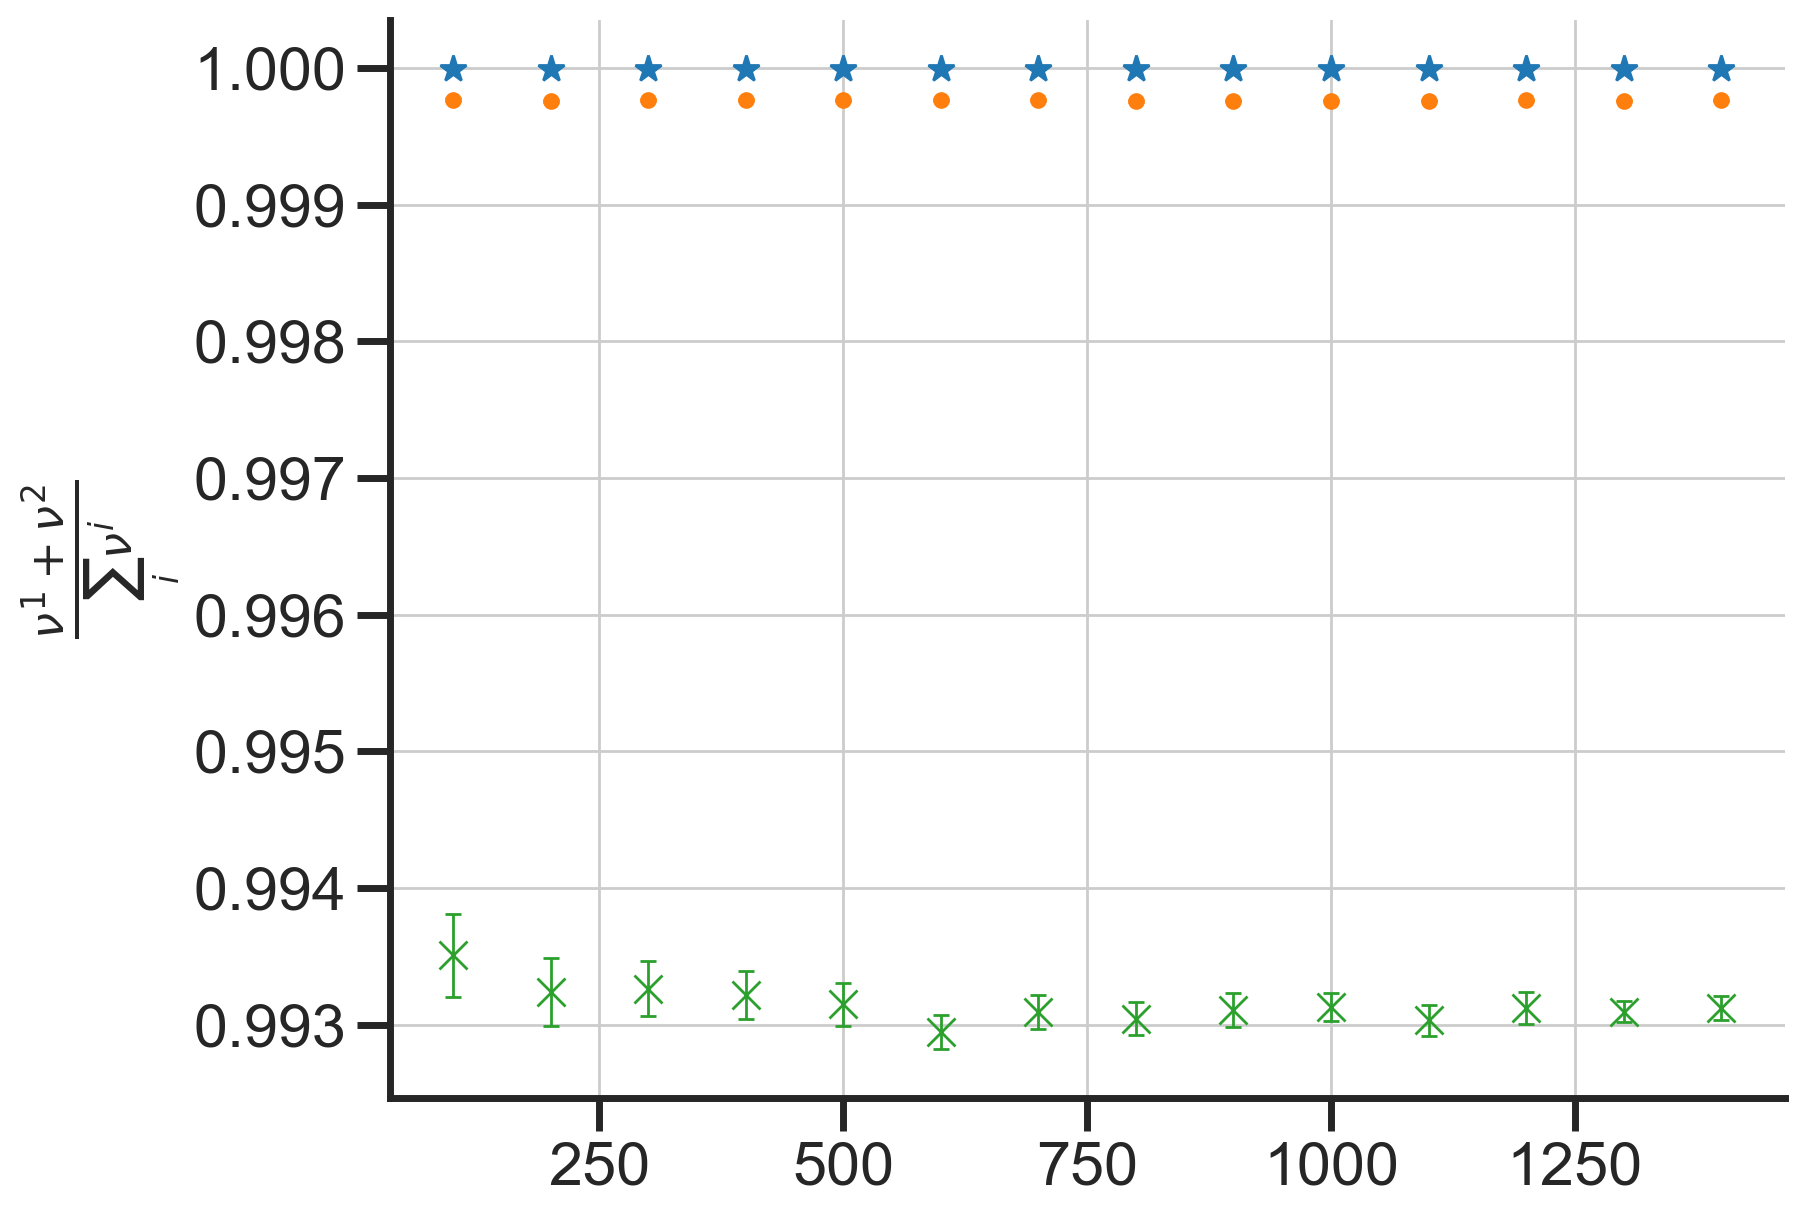

In [137]:
# with two factors
fig, ax = plt.subplots()
ax.errorbar(
    tab_n,
    inertia_b01[:, 1],
    yerr=error_b01[:, 1],
    markersize=markersize,
    elinewidth=1,
    fmt="*",
    capsize=capsize,
    label="$b=$ Uniform [0, 1]",
)
ax.errorbar(
    tab_n,
    inertia_b14[:, 1],
    yerr=error_b14[:, 1],
    markersize=markersize,
    elinewidth=1,
    fmt=".",
    capsize=capsize,
    label="$b=$ Uniform [1, 4]",
)
ax.errorbar(
    tab_n,
    inertia_b010[:, 1],
    yerr=error_b010[:, 1],
    markersize=markersize,
    elinewidth=1,
    fmt="x",
    capsize=capsize,
    label="$b=$ Uniform [0, 10]",
)
ax.set_ylabel(r"$\frac{\nu^1 + \nu^2}{\sum_{i} \nu^i}$")
# fig.savefig(f"figures/ratio_nu1_nu2_sum_nu_different_b.pdf", bbox_inches="tight")
plt.show()

## Plot of RHS in $L_1$ error between $\mathcal{L}_{t}$ and $\mathcal{L}_{t}^{PCA}$

For any $p \geq 1$, 
plot of 
$$
\frac{1}{n}
\sum_{i=1}^{n} \Lambda^{i} \,
\left(\frac{\sum_{k=3}^{n} \nu^{k} \times (u^{i, k})^{2}}{\sum_{k=1}^{n} \nu^{k} \times (u^{i, k})^{2}}\right)^{\frac{p}{2(p+1)}}.
$$
Define also 
$C_{p} = \frac{9}{\sqrt{\pi}} \Gamma(\frac{1+p}{2})^{\frac{1}{p+1}}$. 
To simplify, we take $\Lambda^i = 1$ for all $i$.

In [105]:
def c_func(p):
    return (pow(2, 0.5) / pow(np.pi, 1 / (2 * p))) * pow(
        special.gamma(0.5 * (1 + p)), 1 / p
    )

In [106]:
def C_func(p):
    return (9 / np.sqrt(np.pi)) * pow(special.gamma(0.5 * (1 + p)), 1 / (p + 1))

In [107]:
tab_p = np.linspace(1, 10, 101)

Check that $9 (\frac{c_p}{{\sqrt{2\pi}}})^{\frac{p}{p+1}} = C_p$

In [108]:
test0 = 9 * pow(c_func(tab_p) / np.sqrt(2 * np.pi), tab_p / (tab_p + 1))
test1 = C_func(tab_p)
np.allclose(test0, test1)

True

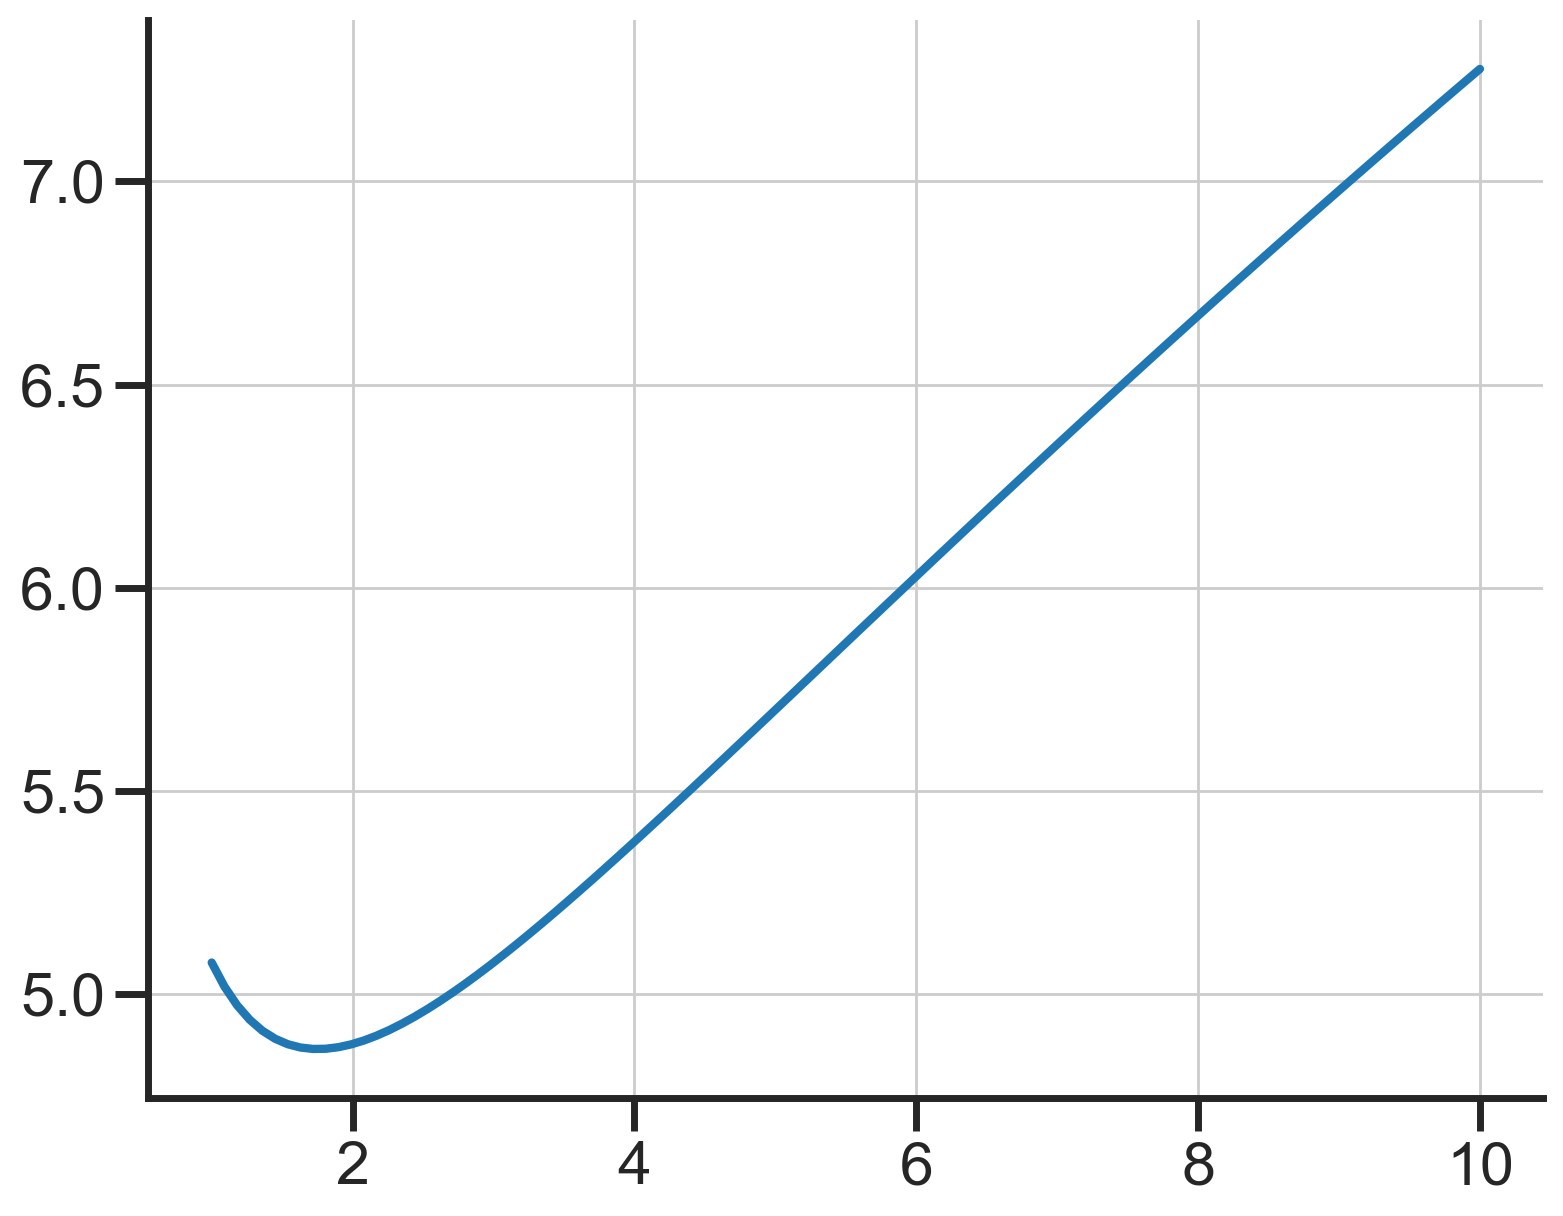

In [109]:
fig, ax = plt.subplots()
ax.plot(tab_p, C_func(p=tab_p))
plt.show()

In [110]:
optimize.minimize(fun=C_func, x0=2)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.864865363532417
        x: [ 1.753e+00]
      nit: 5
      jac: [-1.192e-07]
 hess_inv: [[ 2.165e+00]]
     nfev: 12
     njev: 6

In [111]:
def rhs_func(n, p, b_min, b_max, t=1.0):
    b = np.random.uniform(b_min, b_max, size=n)
    b_rep = np.tile(b, (n, 1))
    rho = np.random.uniform(-1, 1, size=n)
    rho_rep = np.tile(rho, (n, 1))
    cov_X = (
        (rho_rep * rho_rep.T) * (1 - np.exp(-(b_rep + b_rep.T) * t)) / (b_rep + b_rep.T)
    )
    U, eig_X, U_T = np.linalg.svd(cov_X)
    num = np.sum(eig_X[2:, None] * pow(U[2:, :], 2), axis=0)
    denom = np.sum(eig_X[:, None] * pow(U[:, :], 2), axis=0)
    res = np.sum(pow(num / denom, 0.5 * p / (p + 1)))
    return res / n


def mc_rhs_func(tab_n, n_mc, p, b_min, b_max):
    bound = np.zeros(tab_n.shape[0])
    bound_err = np.zeros(tab_n.shape[0])

    for idx in tqdm(range(tab_n.shape[0])):
        list = []
        for _ in range(n_mc):
            _rhs = rhs_func(n=tab_n[idx], p=p, b_min=b_min, b_max=b_max)
            list.append(_rhs)
        bound[idx] = np.array(list).mean()
        bound_err[idx] = 1.96 * np.array(list).std() / np.sqrt(n_mc)
    return bound, bound_err

In [112]:
n_mc = 30
tab_n = np.arange(100, 1500, 100)

In [113]:
bound_01, bound_err_01 = mc_rhs_func(tab_n=tab_n, n_mc=n_mc, p=1, b_min=0, b_max=1)
bound_14, bound_err_14 = mc_rhs_func(tab_n=tab_n, n_mc=n_mc, p=1, b_min=1, b_max=4)
bound_010, bound_err_010 = mc_rhs_func(tab_n=tab_n, n_mc=n_mc, p=1, b_min=0, b_max=10)

 79%|███████▊  | 11/14 [00:17<00:04,  1.56s/it]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(
    tab_n,
    bound_01,
    yerr=bound_err_01,
    markersize=markersize,
    elinewidth=elinewidth,
    fmt="*",
    capsize=capsize,
    label="$b=$ Uniform [0, 1]",
)
ax.errorbar(
    tab_n,
    bound_14,
    yerr=bound_err_14,
    markersize=markersize,
    elinewidth=elinewidth,
    fmt=".",
    capsize=capsize,
    label="$b=$ Uniform [1, 4]",
)
ax.errorbar(
    tab_n,
    bound_010,
    yerr=bound_err_010,
    markersize=markersize,
    elinewidth=elinewidth,
    fmt="x",
    capsize=capsize,
    label="$b=$ Uniform [0, 10]",
)
ax.set_xlabel("$n$")
ax.legend()
plt.show()

### Monte Carlo

<font color="red">TODO: check and finish Monte Carlo estimation of 
$$
\sum_{i=1}^{n} \mathbb{E}[| 1_{A \leq X_t^i} - 1_{A \leq \sqrt{\nu^1} G^1 u^{1,i} + \sqrt{\nu^2} G^2 u^{2,i}} | ]
$$
</font>

In [ ]:
def mc_bound(n, n_mc, b_min=0, b_max=1, t=1, A=0):
    b = np.random.uniform(b_min, b_max, size=n)
    b_rep = np.tile(b, (n, 1))
    rho = np.random.uniform(-1, 1, size=n)
    rho_rep = np.tile(rho, (n, 1))
    cov_X = (
        (rho_rep * rho_rep.T) * (1 - np.exp(-(b_rep + b_rep.T) * t)) / (b_rep + b_rep.T)
    )
    U, eig_X, _ = np.linalg.svd(cov_X)

    normal = np.random.randn(n, n_mc)
    return normal, eig_X, U

In [ ]:
sum_mc = np.sum(mc_bound(n=100, n_mc=1000, b_min=0, b_max=5, A=0).mean(axis=1))

### L1 error estimate

In [ ]:
U_cov_X, eigs_cov_X, _ = np.linalg.svd(cov_X)

for i in range(3):
    _a = (tab_rho[i] ** 2) * (1.0 - np.exp(-2 * tab_b[i] * T)) / (2.0 * tab_b[i])
    _b = np.sum([eigs_cov_X[k] * U_cov_X[i, k] ** 2 for k in range(n_firms)])
    assert np.allclose(_a, _b)

# _scenario_name = list_scenarios[-1]
# lhs = np.mean(np.absolute(loss_dict[_scenario_name] - loss_pca[_scenario_name]))
# print(lhs)

# sanity check with full PCA
np.random.seed(SEED)

for _scenario_name in sub_scenarios:
    print(_scenario_name)

    G_ind = np.random.randn(n_firms, n_mc)
    vec_A = mean_A[_scenario_name][:, None] + std_A[_scenario_name][:, None] * G_ind

    G = np.random.randn(n_firms, n_mc)

    vec_X = np.zeros_like(vec_A)
    for k in tqdm(range(n_firms)):
        vec_X += np.sqrt(eigs_cov_X[k]) * U_cov_X[:, k][:, None] * G[k, :]

    vec_X_pca = np.zeros_like(vec_A)
    for k in tqdm(range(n_factors)):
        vec_X_pca += np.sqrt(eigs_cov_X[k]) * U_cov_X[:, k][:, None] * G[k, :]

    # Summing over all firms to get loss
    _loss = np.sum(tab_Lambda[:, None] * 1.0 * (vec_A <= vec_X), axis=0)
    _loss_pca = np.sum(tab_Lambda[:, None] * 1.0 * (vec_A <= vec_X_pca), axis=0)

    mc_abs = np.absolute(_loss - _loss_pca)
    l1_error = mc_abs.mean()
    error_95 = 1.96 * mc_abs.std() / np.sqrt(n_mc)
    print(f"l1_error: {l1_error} +/- {error_95}")


_num = np.sum(eigs_cov_X[None, 2:] * (U_cov_X[:, 2:] ** 2), axis=1)
_denom = np.sum(eigs_cov_X[None, :] * (U_cov_X**2), axis=1)
_frac = np.sqrt(_num / _denom)
rhs = (
    np.sum(tab_Lambda * (np.absolute(tab_rho) / np.sqrt(1.0 - tab_rho**2)) * _frac)
    / np.pi
)
print(rhs)

S = 0
for i in range(n_firms):
    tmp0 = np.sum([eigs_cov_X[j] * U_cov_X[i, j] ** 2 for j in range(2, n_firms)])
    tmp1 = np.sum([eigs_cov_X[j] * U_cov_X[i, j] ** 2 for j in range(n_firms)])
    S += (
        tab_Lambda[i] * np.abs(tab_rho[i]) / np.sqrt(1.0 - tab_rho[i] ** 2)
    ) * np.sqrt(tmp0 / tmp1)

rhs_with_loop = S / np.pi
print(rhs_with_loop)

## Optimal emission decomposition for a specific firm, scenario, and sector

For a given firm, we pick one SSP and one sector. 

We want to plot the different 
emissions $\widehat{\gamma}_{e,t}$ for each energy type $e$.

We consider three different energy types:

- Power/CO2e ratio $\theta_{e} = \frac{1}{3600} \frac{1}{Emission \, factor}  \, \rm{kW / kgCO_2e}$

In [124]:
energy_types = ["Natural gas", "Elec (Nuclear)", "Elec (Coal)"]
theta_natural_gas = (1.0 / 0.202) / 3600.0
theta_elec_nuclear = (1.0 / 0.012) / 3600.0
theta_elec_coal = (1.0 / 0.820) / 3600.0
theta = np.array([theta_natural_gas, theta_elec_nuclear, theta_elec_coal])
alpha = np.array([0.05, 0.16, 0.16])

# Set parameters
params = {
    "P0": 1.0,
    "r": 0.05,
    "sig": 0.1,
    "a": 0.0,
    "b": 0.0,
    "c": 1.0 * np.array([1.0, 1.0, 1.0]),
    "n_units": 1,
    "w_1": 1e-4,
    # "w_2": 0.0,
    "w_2": 1e-4,
    "alpha": alpha,
    "beta": np.array([1.0, 1.0, 1.0]),
    "theta": theta,
    "T_final": T_final,
}

nT = 200
tab_T = np.linspace(0.0, T_final, nT)

In [138]:
scenario = SCENARIOS[4]
sector = SECTORS[1]
print(scenario, sector)

SSP5-85 (Baseline) Industrial Sector


In [139]:
firm = Firm(**params, scenario=scenario, sector=sector)
gam_opt = firm.gamma_optimal_energy(tab_T)

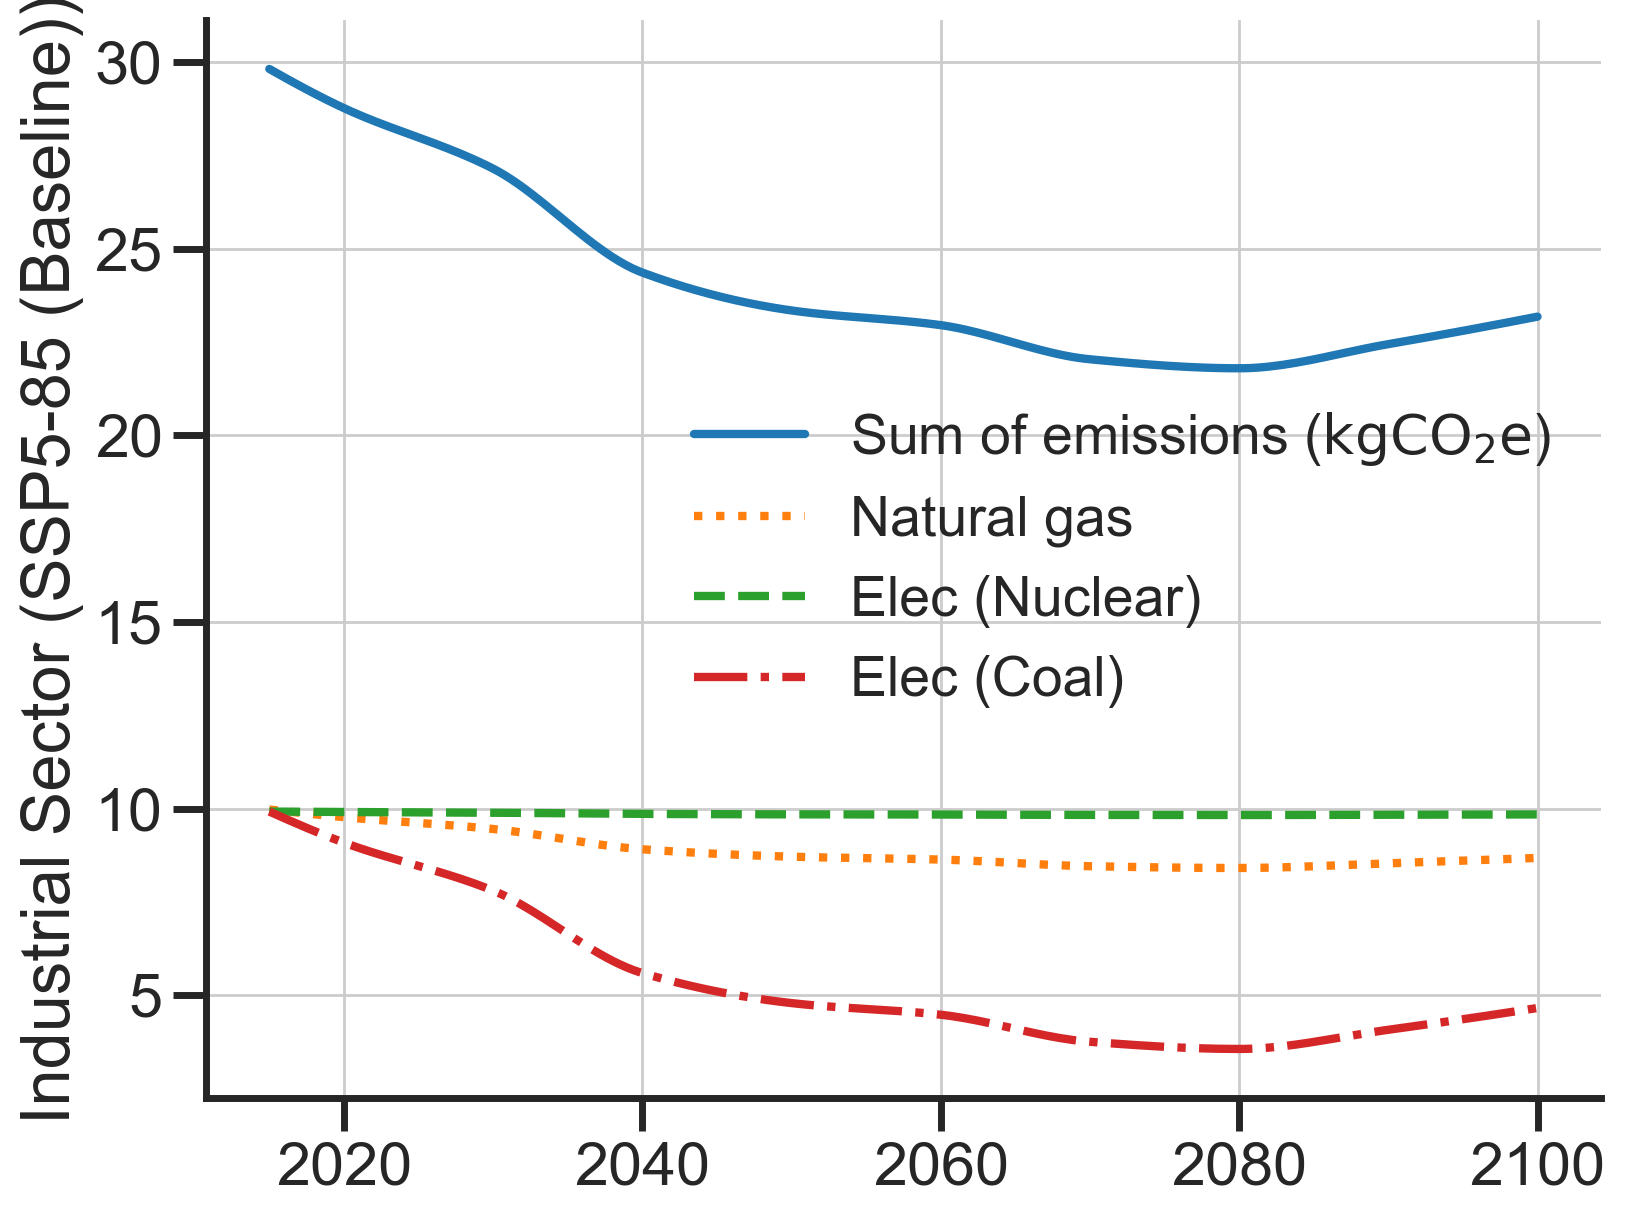

In [ ]:
linestyles = ["dotted", "dashed", "dashdot"]

fig, ax = plt.subplots()
ax.plot(
    T_ssp_initial + tab_T,
    gam_opt.sum(axis=0),
    label="Sum of emissions (${\\mathrm{kgCO_2e}}$)",
)
for i in range(gam_opt.shape[0]):
    plt.plot(
        T_ssp_initial + tab_T,
        gam_opt[i, :],
        linestyle=linestyles[i],
        label=energy_types[i],
    )
ax.set_ylabel(f"{sector} ({scenario})")
ax.legend(framealpha=0, fontsize="small", ncol=1)
# fig.savefig(
#     "figures/optimal_emissions_per_energy_ssp5_industrial_sector.pdf",
#     bbox_inches="tight",
# )
plt.show()